In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/warmup-datavidia/sample_submission.csv
/kaggle/input/warmup-datavidia/train.csv
/kaggle/input/warmup-datavidia/test.csv


# Import Additional Libraries

In [72]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
import shap
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import pickle

import warnings
warnings.filterwarnings("ignore")

# Global Variables

In [73]:
seed = 20

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

In [74]:
TRAIN_DIR = "/kaggle/input/warmup-datavidia/train.csv" # change to local directory if needed
TEST_DIR = "/kaggle/input/warmup-datavidia/test.csv" # change to local directory if needed

train = pd.read_csv(TRAIN_DIR,index_col=0)
test = pd.read_csv(TEST_DIR,index_col=0)

x = train.copy()
y = train["Peningkatan Suhu Rata - Rata ° C"]

# Dataset Understanding

In [75]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [76]:
train.head()

Negara/Tahun  Emisi Savanna Api  Emisi Kebakaran Hutan  \
0  Afghanistan/1990            14.7237                 0.0557   
1  Afghanistan/1991            14.7237                 0.0557   
2  Afghanistan/1992            14.7237                 0.0557   
3  Afghanistan/1993            14.7237                 0.0557   
4  Afghanistan/1994            14.7237                 0.0557   

   Emisi Residu Tanaman  Emisi Budidaya Padi  \
0              205.6077               686.00   
1              209.4971               678.16   
2              196.5341               686.00   
3              230.8175               686.00   
4              242.0494               705.60   

   Emisi Tanah Organik Yang Dikeringkan (Co2)  Emisi Pembuatan Pestisida  \
0                                         0.0                  11.807483   
1                                         0.0                  11.712073   
2                                         0.0                  11.712073   
3                                         0.0                  11.712073   
4                                         0.0                  11.712073   

   Emisi Transportasi Makanan  Lahan Hutan  Konversi Hutan Bersih  \
0                     63.1152    -2388.803                    0.0   
1                     61.2125    -2388.803                    0.0   
2                     53.3170    -2388.803                    0.0   
3                     54.3617    -2388.803                    0.0   
4                     53.9874    -2388.803                    0.0   

   Emisi Konsumsi Rumah Tangga Makanan  Emisi Ritel Makanan  \
0                              79.0851             109.6446   
1                              80.4885             116.6789   
2                              80.7692             126.1721   
3                              85.0678              81.4607   
4                              88.8058              90.4008   

   Emisi Penggunaan Listrik Di Pertanian  Emisi Kemasan Makanan  \
0                                14.2666              67.631366   
1                                11.4182              67.631366   
2                                 9.2752              67.631366   
3                                 9.0635              67.631366   
4                                 8.3962              67.631366   

   Emisi Sistem Agrifood Pembuangan Limbah  Emisi Pengolahan Makanan  \
0                                 691.7888                 252.21419   
1                                 710.8212                 252.21419   
2                                 743.6751                 252.21419   
3                                 791.9246                 252.21419   
4                                 831.9181                 252.21419   

   Emisi Manufaktur Pupuk  Emisi IPPU  Emisi Kotoran Diterapkan Pada Tanah  \
0                 11.9970    209.9778                             260.1431   
1                 12.8539    217.0388                             268.6292   
2                 13.4929    222.1156                             264.7898   
3                 14.0559    201.2057                             261.7221   
4                 15.1269    182.2905                             267.6219   

   Emisi Pupuk Kandang Di Padang Rumput  Emisi Manajemen Pupuk  \
0                             1590.5319               319.1763   
1                             1657.2364               342.3079   
2                             1653.5068               349.1224   
3                             1642.9623               352.2947   
4                             1689.3593               367.6784   

   Emisi Kebakaran Di Tanah Organik  \
0                               0.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   Emisi Kebakaran Di Hutan Tropis Yang Lembab  \
0                                          0.0   
1                                      

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5603 entries, 0 to 5602
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Negara/Tahun                                 5603 non-null   object 
 1   Emisi Savanna Api                            5578 non-null   float64
 2   Emisi Kebakaran Hutan                        5528 non-null   float64
 3   Emisi Residu Tanaman                         4485 non-null   float64
 4   Emisi Budidaya Padi                          5603 non-null   float64
 5   Emisi Tanah Organik Yang Dikeringkan (Co2)   5603 non-null   float64
 6   Emisi Pembuatan Pestisida                    5603 non-null   float64
 7   Emisi Transportasi Makanan                   5603 non-null   float64
 8   Lahan Hutan                                  5206 non-null   float64
 9   Konversi Hutan Bersih                        5206 non-null   float64
 10  Emisi

In [78]:
train.describe()

Emisi Savanna Api  Emisi Kebakaran Hutan  Emisi Residu Tanaman  \
count        5578.000000            5528.000000           4485.000000   
mean         1229.654445             924.275199            949.205076   
std          5472.353828            3692.584881           3498.477164   
min             0.000000               0.000000              0.000200   
25%             0.000000               0.000000             10.921100   
50%             1.657900               0.661850             98.037400   
75%           114.309200              71.094900            356.216100   
max        114616.401100           52227.630600          30638.533800   

       Emisi Budidaya Padi  Emisi Tanah Organik Yang Dikeringkan (Co2)  \
count          5603.000000                                 5603.000000   
mean           4241.101704                                 3471.791570   
std           17599.627763                                15488.661938   
min               0.000000                                    0.000000   
25%             172.219300                                    0.000000   
50%             515.517200                                    0.000000   
75%            1551.410550                                  694.164500   
max          164915.255600                               232118.469400   

       Emisi Pembuatan Pestisida  Emisi Transportasi Makanan    Lahan Hutan  \
count                5603.000000                 5603.000000    5206.000000   
mean                  327.522289                 1823.138303  -18145.654062   
std                  1445.484865                 5306.417931   81045.735821   
min                     0.000000                    0.000100 -797183.079000   
25%                     5.000000                   26.262663   -3224.371500   
50%                    12.328281                  176.065300     -69.534600   
75%                   106.981731                 1135.649750       0.000000   
max                 16459.000000                62048.167300  171121.076000   

       Konversi Hutan Bersih  Emisi Konsumsi Rumah Tangga Makanan  \
count           5.206000e+03                          5214.000000   
mean            1.845452e+04                          4290.229336   
std             1.080050e+05                         20691.807663   
min             0.000000e+00                             0.000000   
25%             0.000000e+00                            10.011225   
50%             4.461600e+01                           136.267400   
75%             4.734968e+03                          1357.825900   
max             1.605106e+06                        344626.339200   

       Emisi Ritel Makanan  Emisi Penggunaan Listrik Di Pertanian  \
count          5603.000000                            5603.000000   
mean           1726.558319                            1524.692548   
std            6882.576637                            8356.445935   
min               0.000000                               0.000000   
25%              20.426250                               7.201750   
50%             141.709600                              27.636842   
75%             905.575450                             492.737146   
max          104356.561600                          141904.333600   

       Emisi Kemasan Makanan  Emisi Sistem Agrifood Pembuangan Limbah  \
count            5603.000000                              5603.000000   
mean             1547.357603                              5919.614032   
std             10235.123944                             21758.444098   
min                 0.000000                                 0.340000   
25%                67.631366                                85.683112   
50%                71.287854                               868.007700   
75%               267.072976                              2945.418700   
max            175741.306100                            213289.701600   

       Emisi Pengolahan Makanan  Emisi Manufaktur Pupuk    Emisi IPP

# EDA #1

In [79]:
numerical = train.select_dtypes(exclude='object').columns.to_list()
categorical = train.select_dtypes(include='object').columns.to_list()

## Categorical Unique Values & Count

In [80]:
for col in categorical:
    print(f"==={col}===")
    print(train[col].unique())
    print()

===Negara/Tahun===
['Afghanistan/1990' 'Afghanistan/1991' 'Afghanistan/1992' ...
 'Zimbabwe/2012' 'Zimbabwe/2013' 'Zimbabwe/2014']



In [81]:
for col in categorical:
    print(f"==={col}===")
    print(train[col].value_counts())
    print()

===Negara/Tahun===
Negara/Tahun
Afghanistan/1990         1
Niue/2004                1
Niue/2012                1
Niue/2011                1
Niue/2010                1
                        ..
French Polynesia/1996    1
French Polynesia/1995    1
French Polynesia/1994    1
French Polynesia/1993    1
Zimbabwe/2014            1
Name: count, Length: 5603, dtype: int64



## Null Values

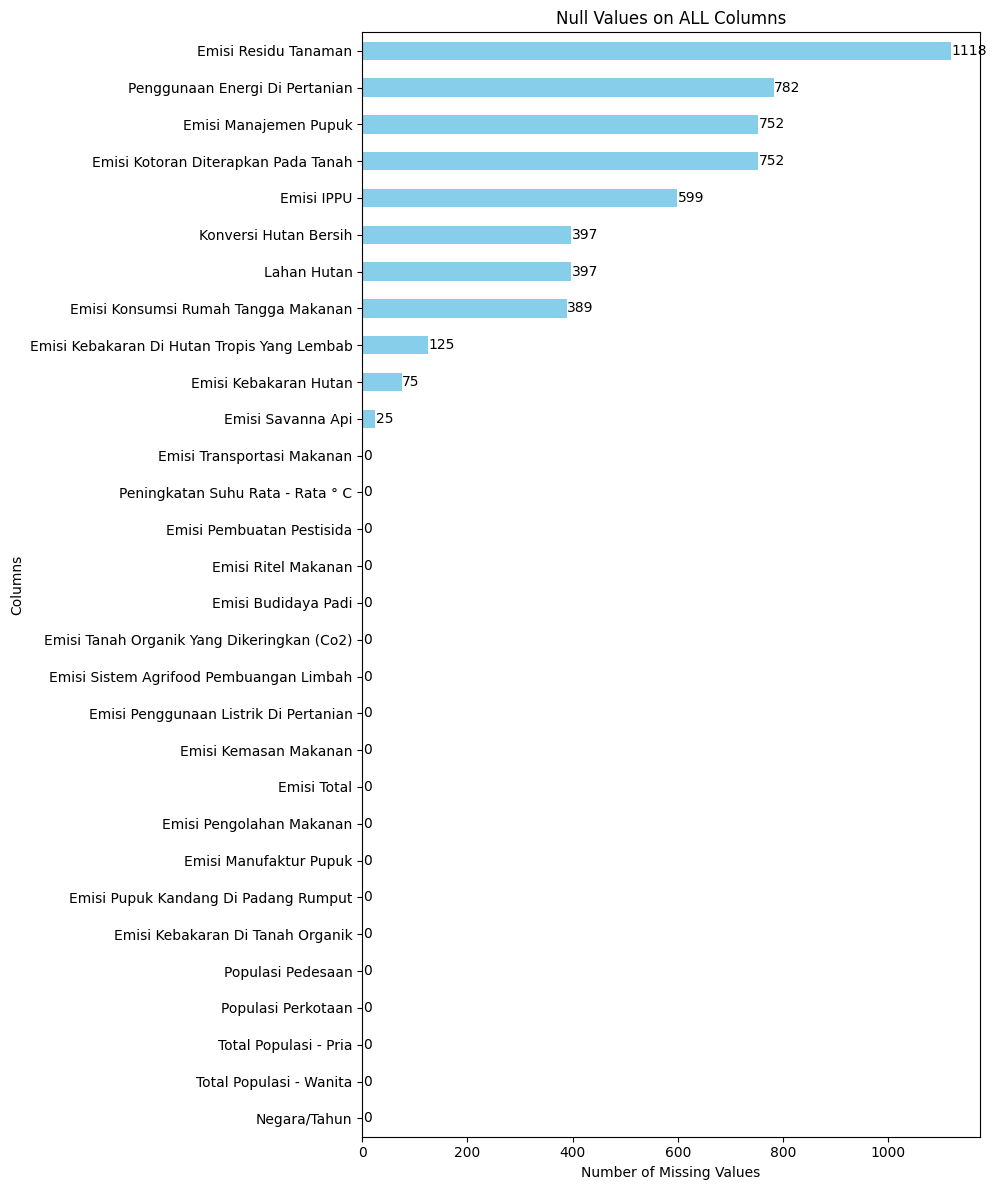

In [82]:
def plot_null(null_dtypes, title):
    plt.figure(figsize=(10, 12))
    ax = null_dtypes.plot(kind='barh', color='skyblue')
    plt.title(title)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    
    for i, (value, name) in enumerate(zip(null_dtypes.values, null_dtypes.index)):
        ax.text(value + 1, i, str(value), va='center')
    
    plt.show()
    
null_col = train.isnull().sum().sort_values(ascending=True)

plot_null(null_col, "Null Values on ALL Columns")

## Violin Plot of Numerical Values

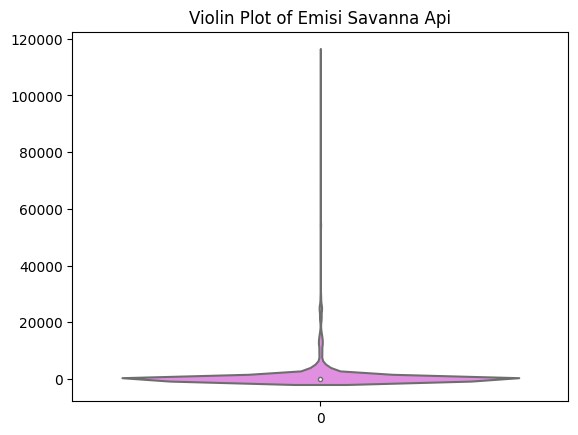

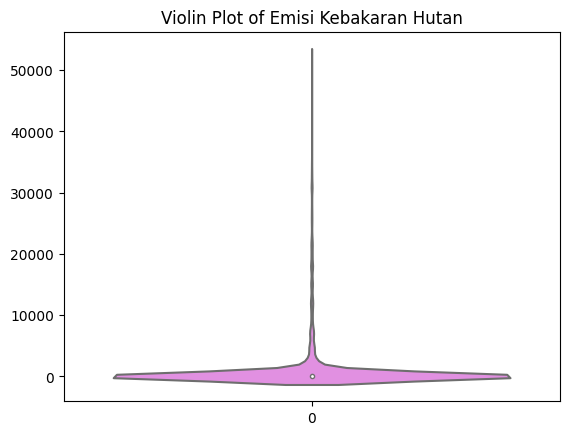

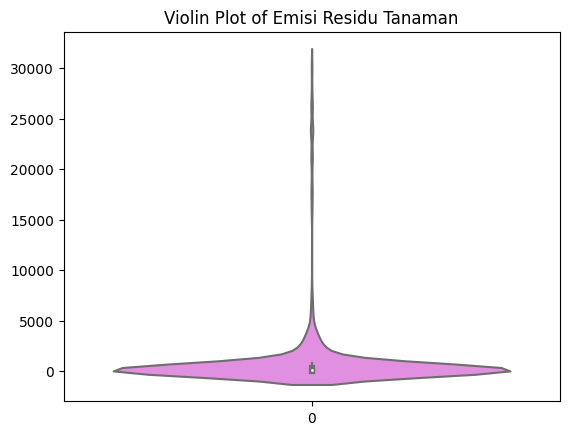

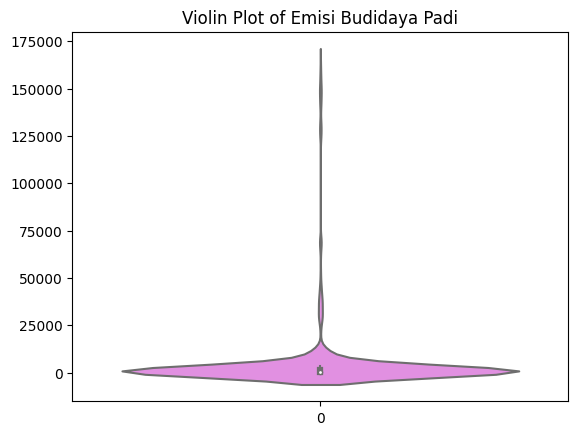

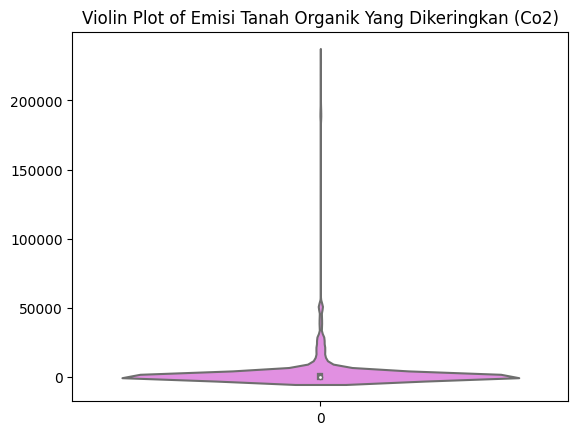

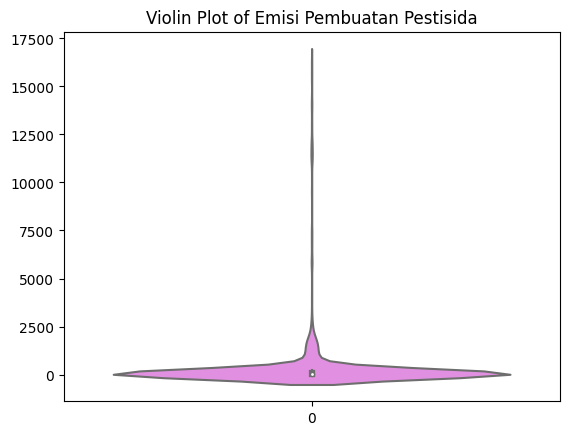

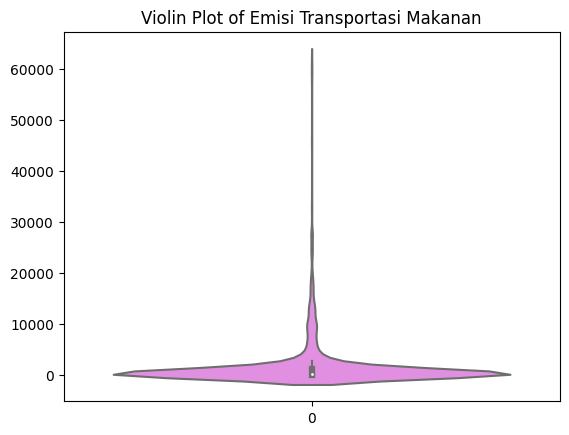

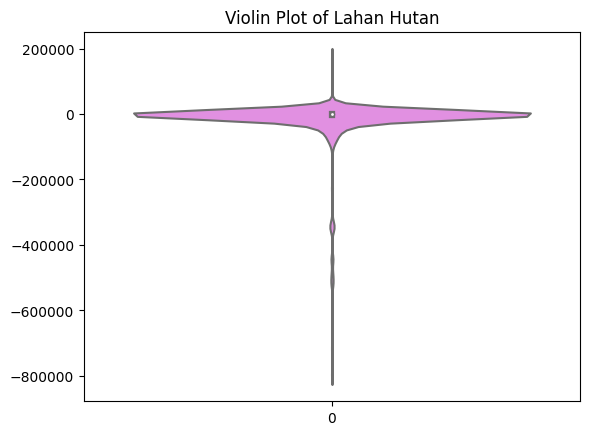

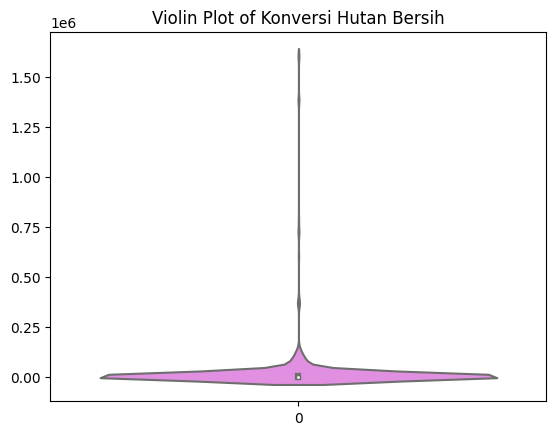

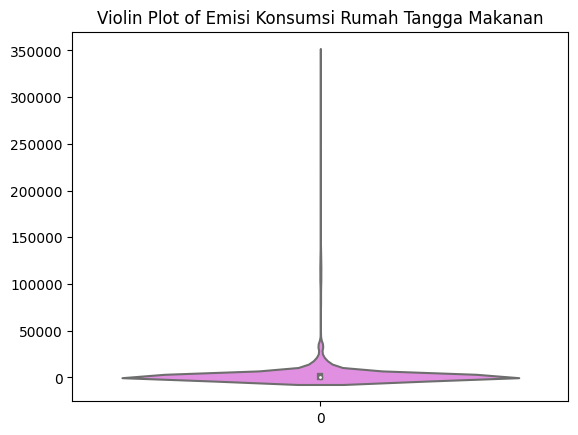

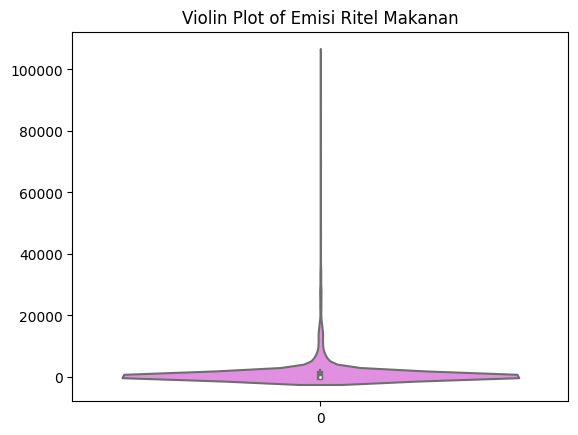

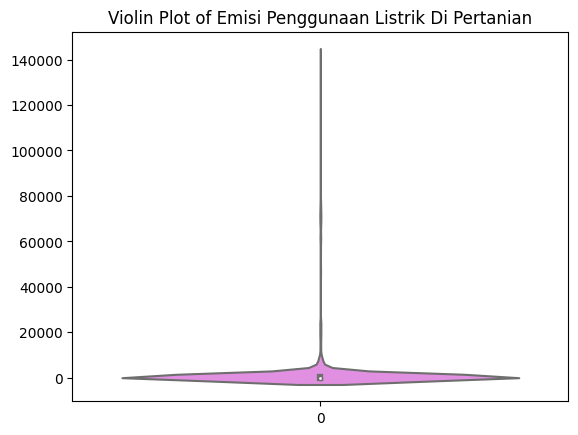

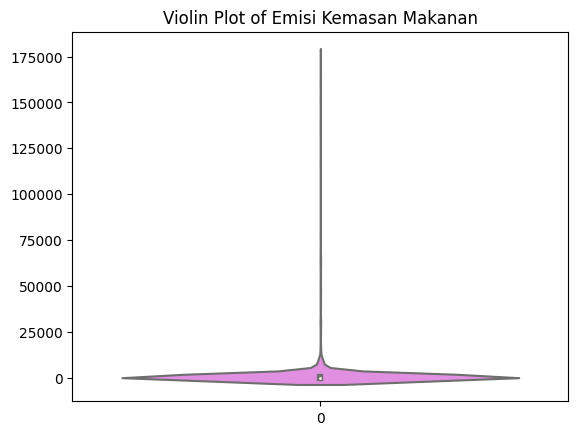

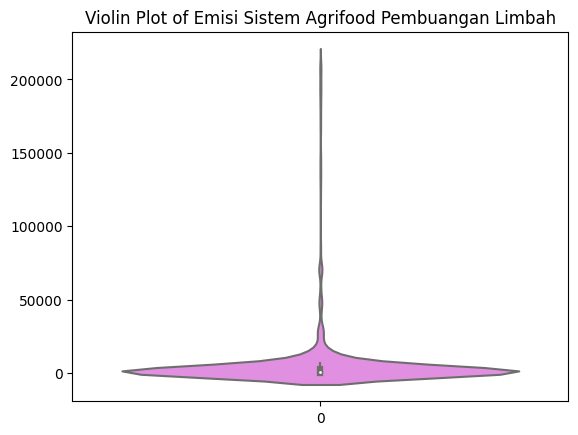

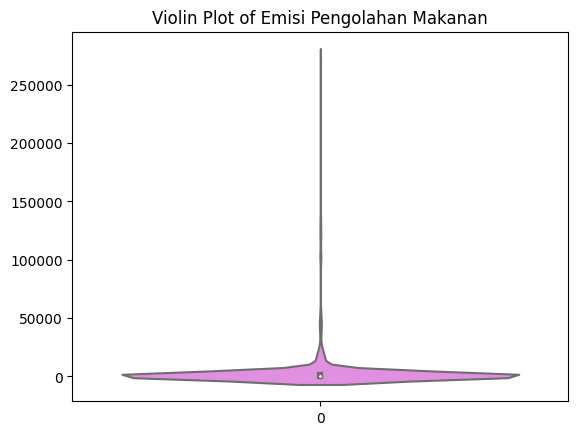

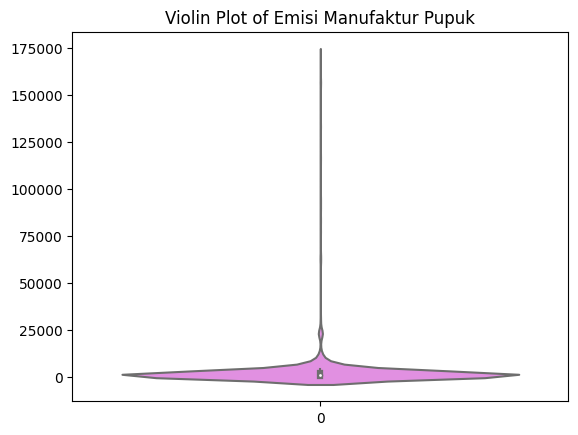

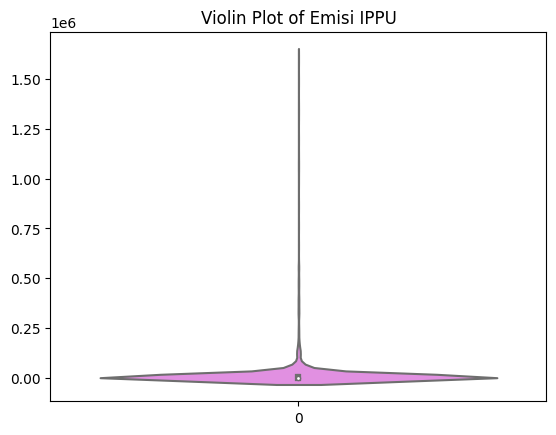

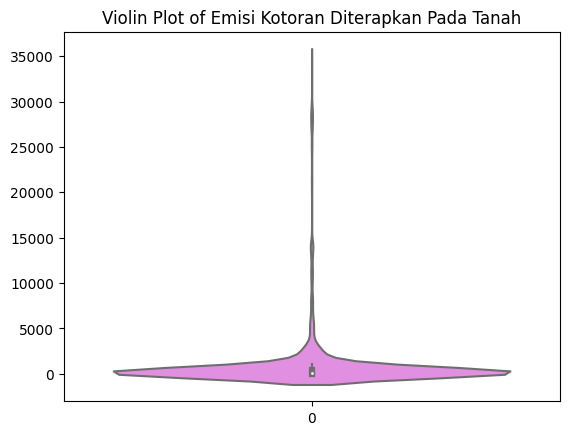

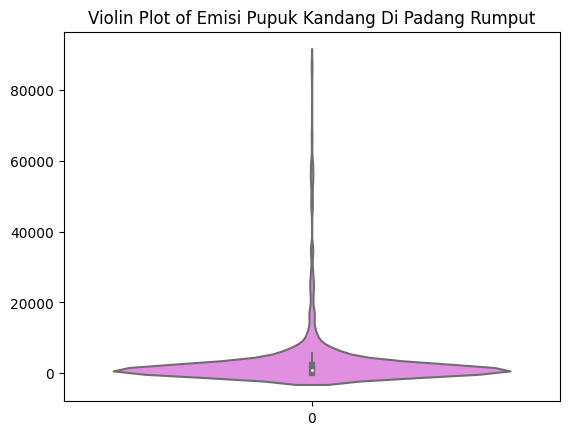

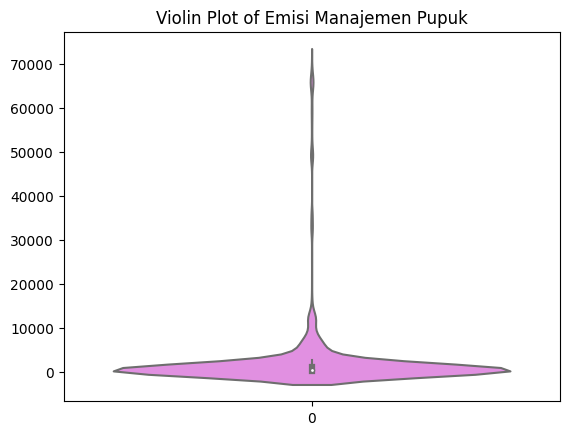

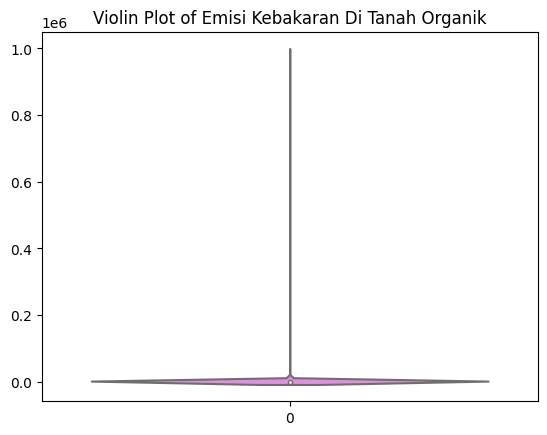

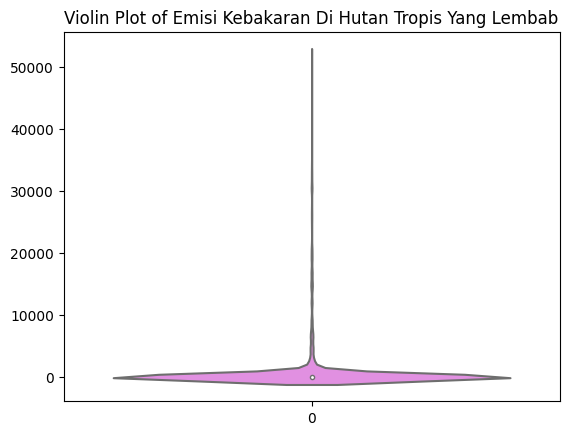

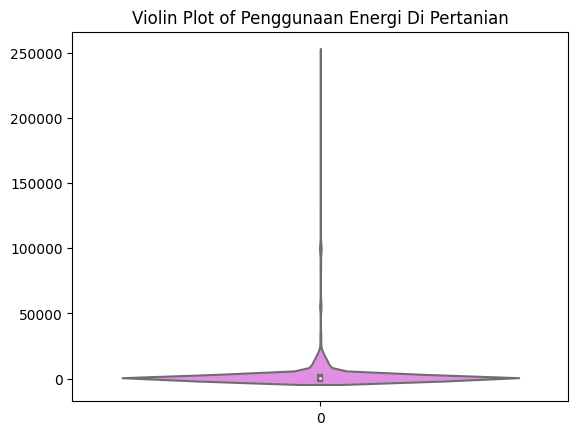

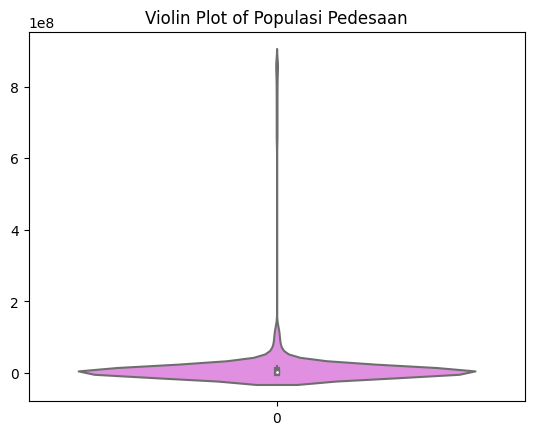

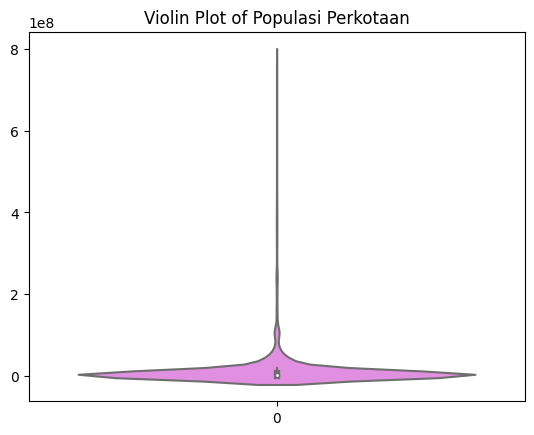

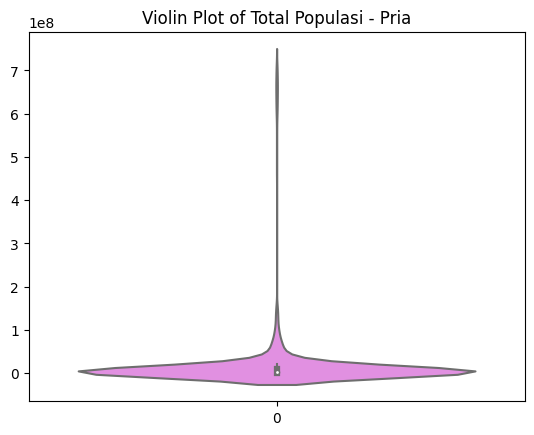

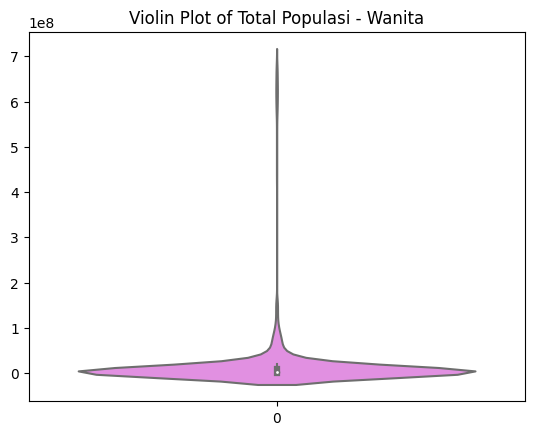

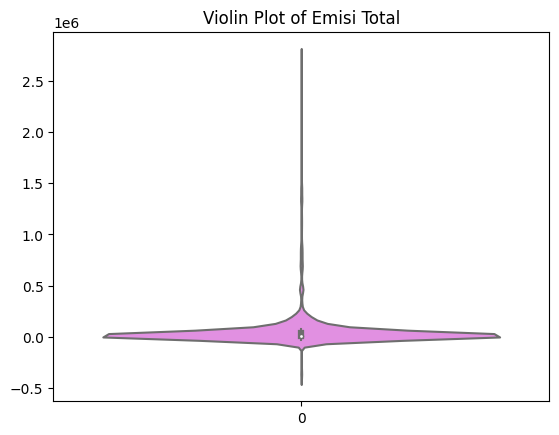

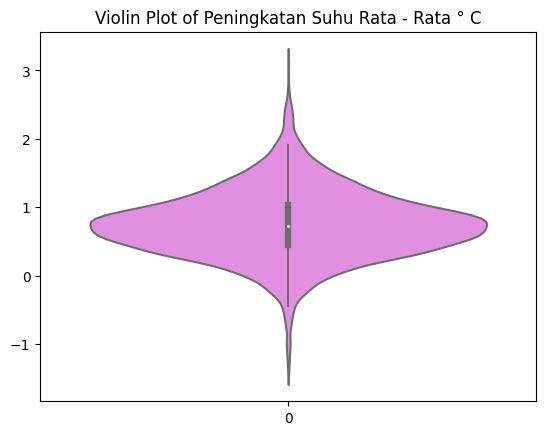

In [83]:
for col in numerical:
    sns.violinplot(train[col], color='violet')
    plt.title(f"Violin Plot of {col}")
    plt.show()

## Boxplot of Numerical Values

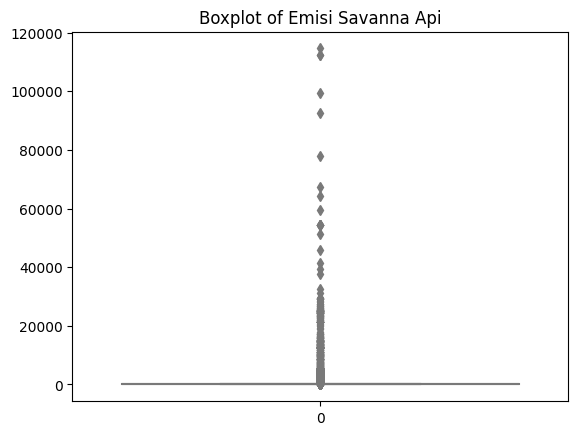

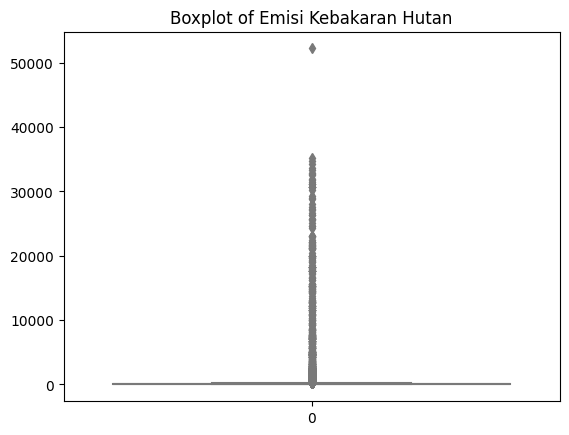

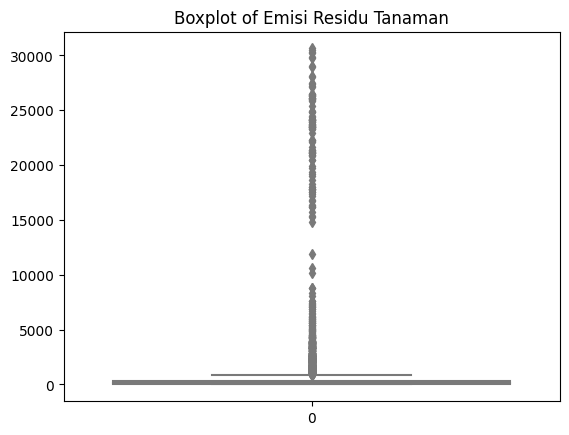

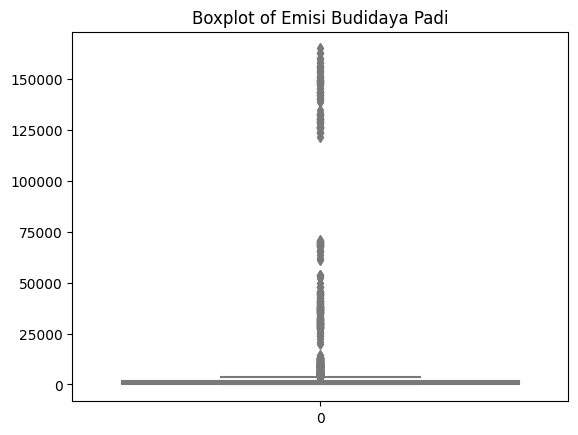

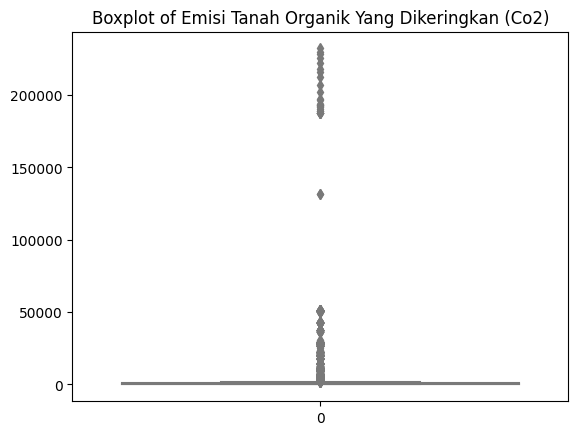

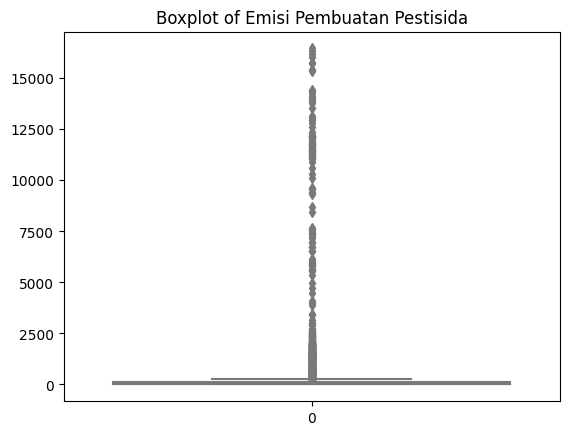

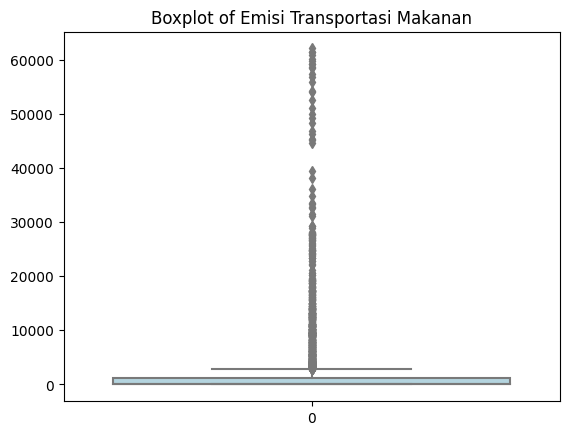

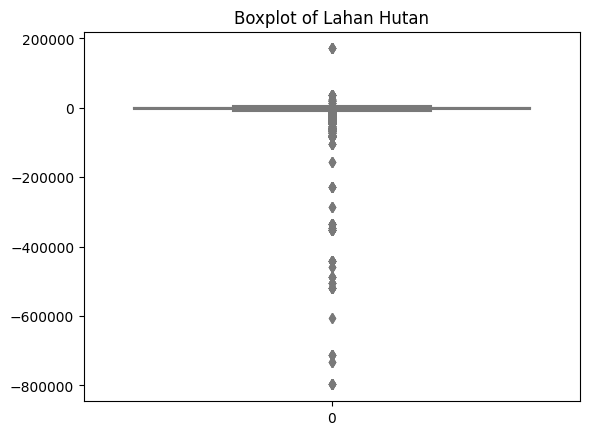

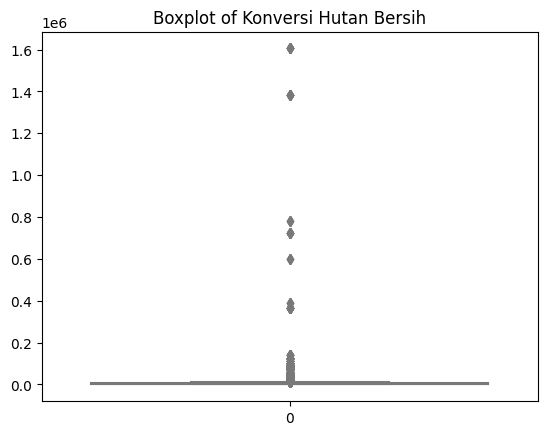

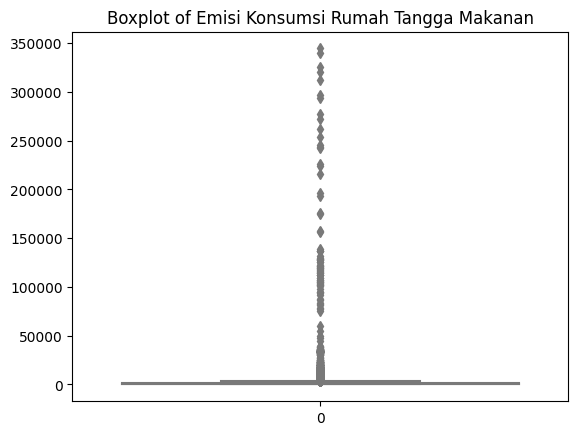

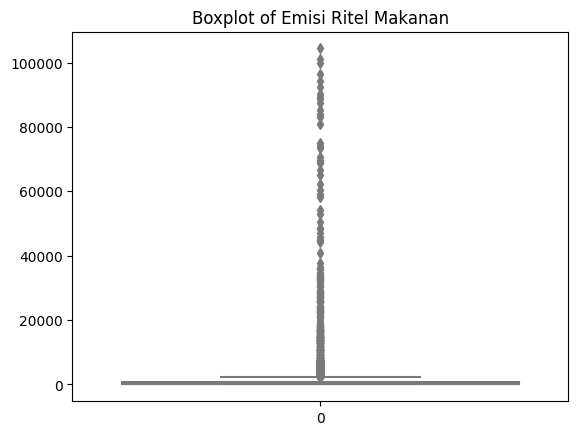

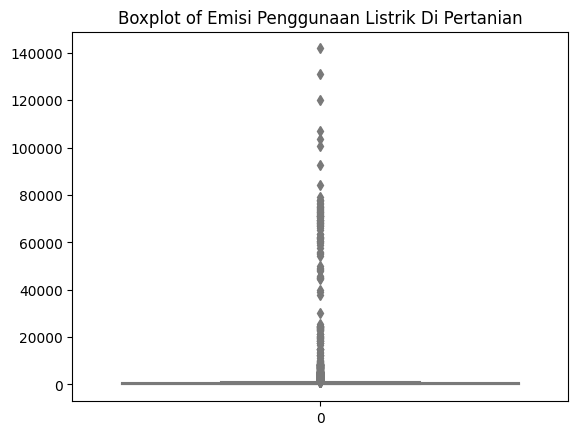

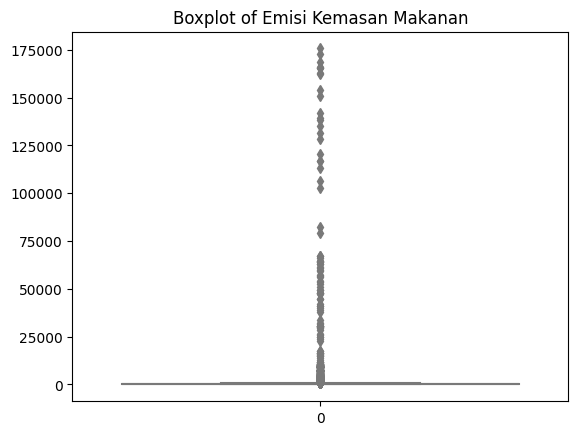

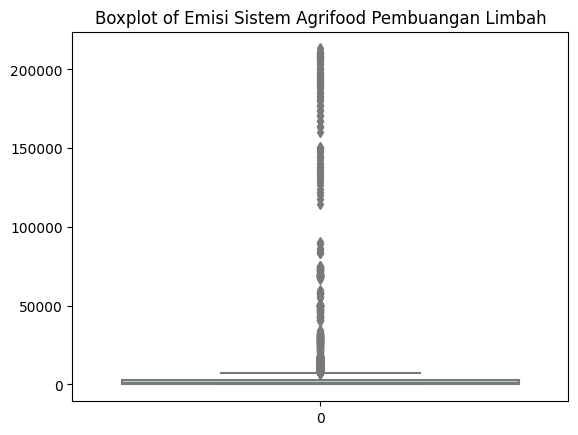

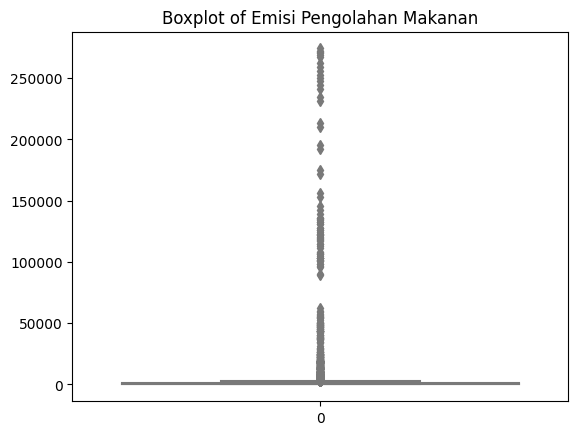

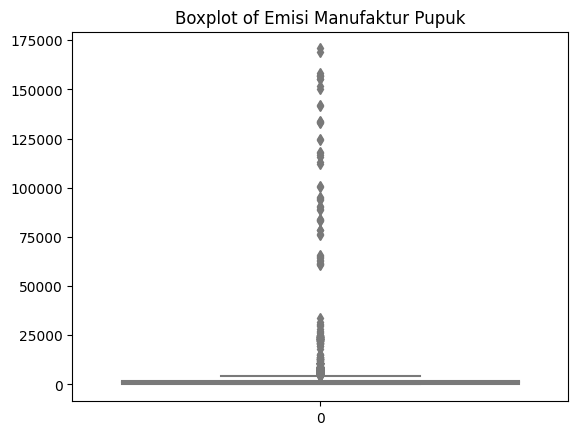

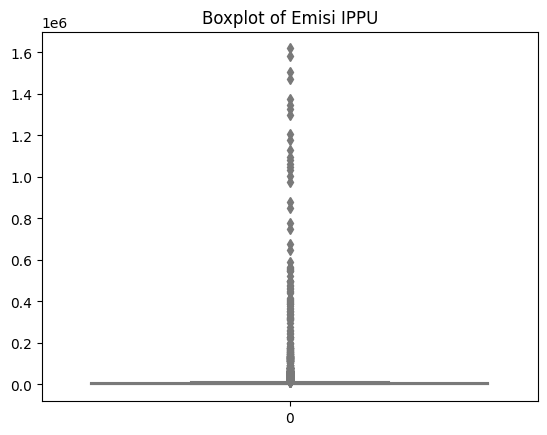

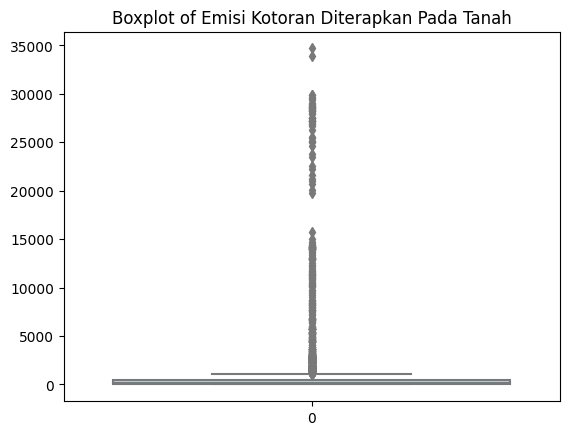

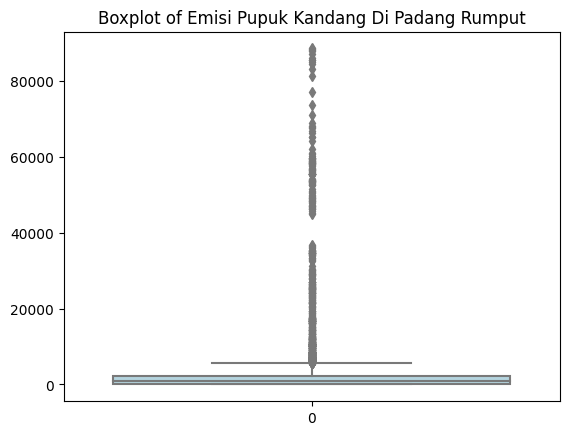

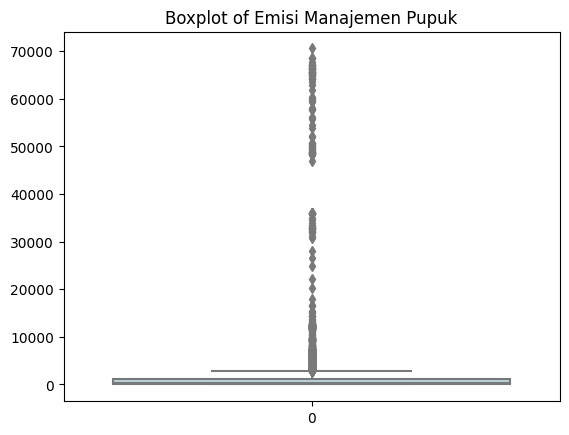

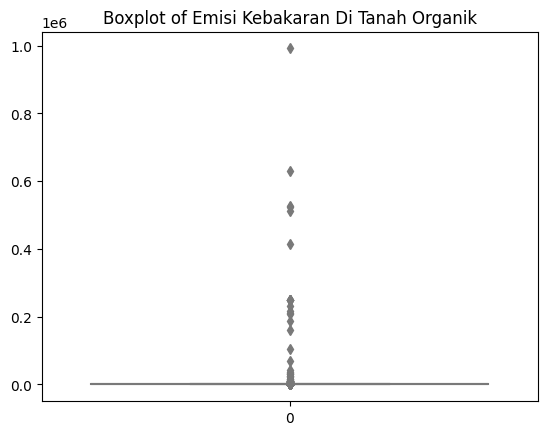

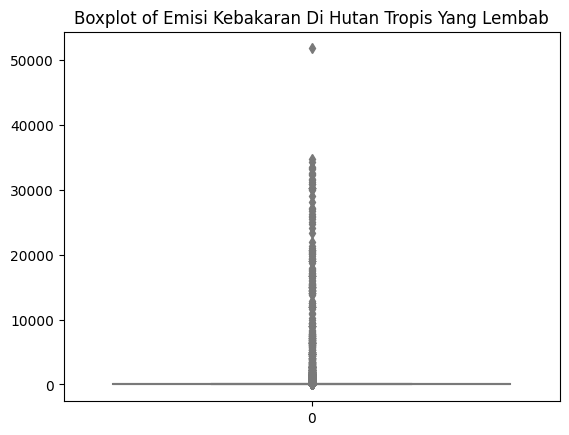

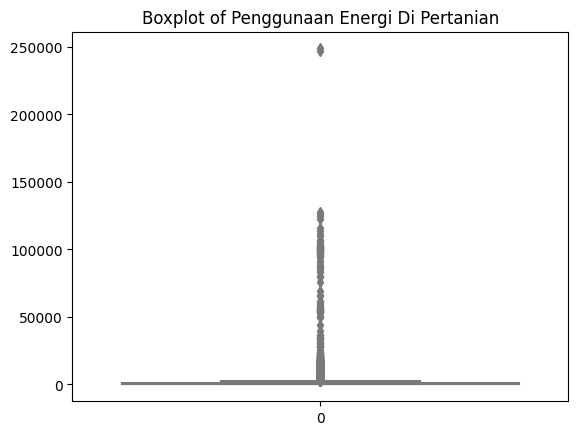

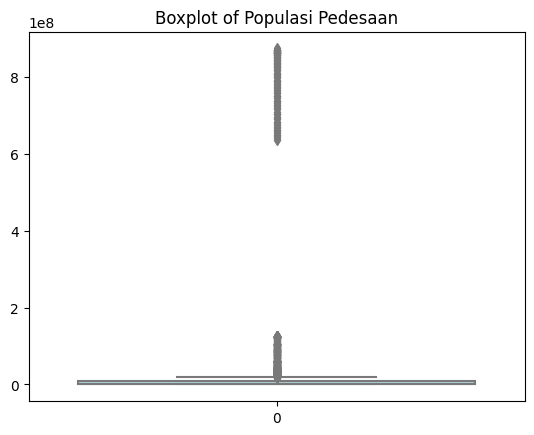

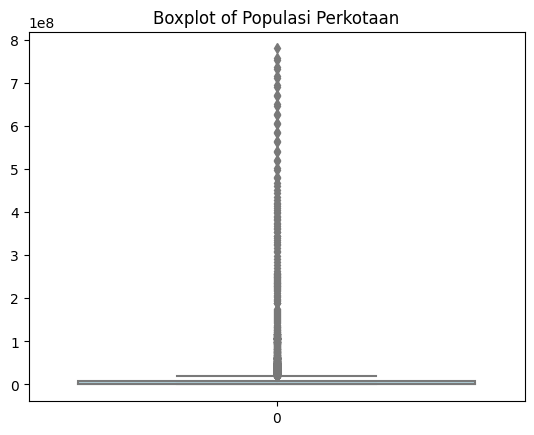

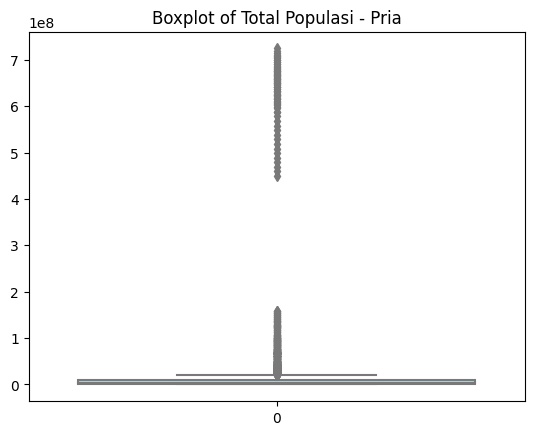

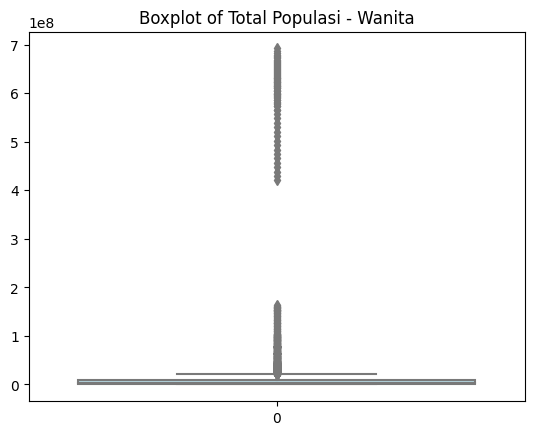

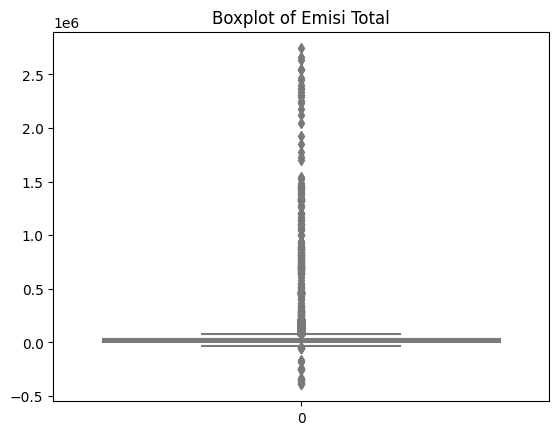

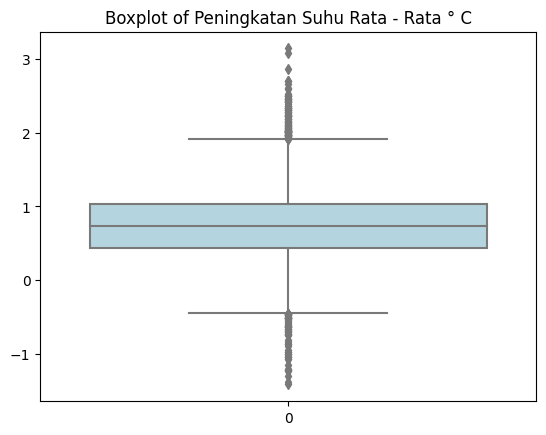

In [84]:
for col in numerical:
    sns.boxplot(train[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
    plt.show()

## Histogram of Numerical Columns

In [85]:
# for col in numerical:
#     sns.histplot(train[col], color='aqua')
#     plt.title(f"Histogram of {col}")
#     plt.show()

## Skewness Analysis

In [86]:
for col in x.select_dtypes(exclude='object').columns:
    if x[col].isnull().any():
        skew_value = skew(x[col].dropna())
        if abs(skew_value) < 0.5:
            print(f"{col}: MEAN (skew = {skew_value:.2f})")
        else:
            print(f"{col}: MEDIAN (skew = {skew_value:.2f})")

Emisi Savanna Api: MEDIAN (skew = 10.48)
Emisi Kebakaran Hutan: MEDIAN (skew = 5.88)
Emisi Residu Tanaman: MEDIAN (skew = 6.03)
Lahan Hutan: MEDIAN (skew = -6.20)
Konversi Hutan Bersih: MEDIAN (skew = 11.54)
Emisi Konsumsi Rumah Tangga Makanan: MEDIAN (skew = 10.06)
Emisi IPPU: MEDIAN (skew = 11.08)
Emisi Kotoran Diterapkan Pada Tanah: MEDIAN (skew = 6.59)
Emisi Manajemen Pupuk: MEDIAN (skew = 6.36)
Emisi Kebakaran Di Hutan Tropis Yang Lembab: MEDIAN (skew = 7.14)
Penggunaan Energi Di Pertanian: MEDIAN (skew = 8.71)


## Numerical Heatmap

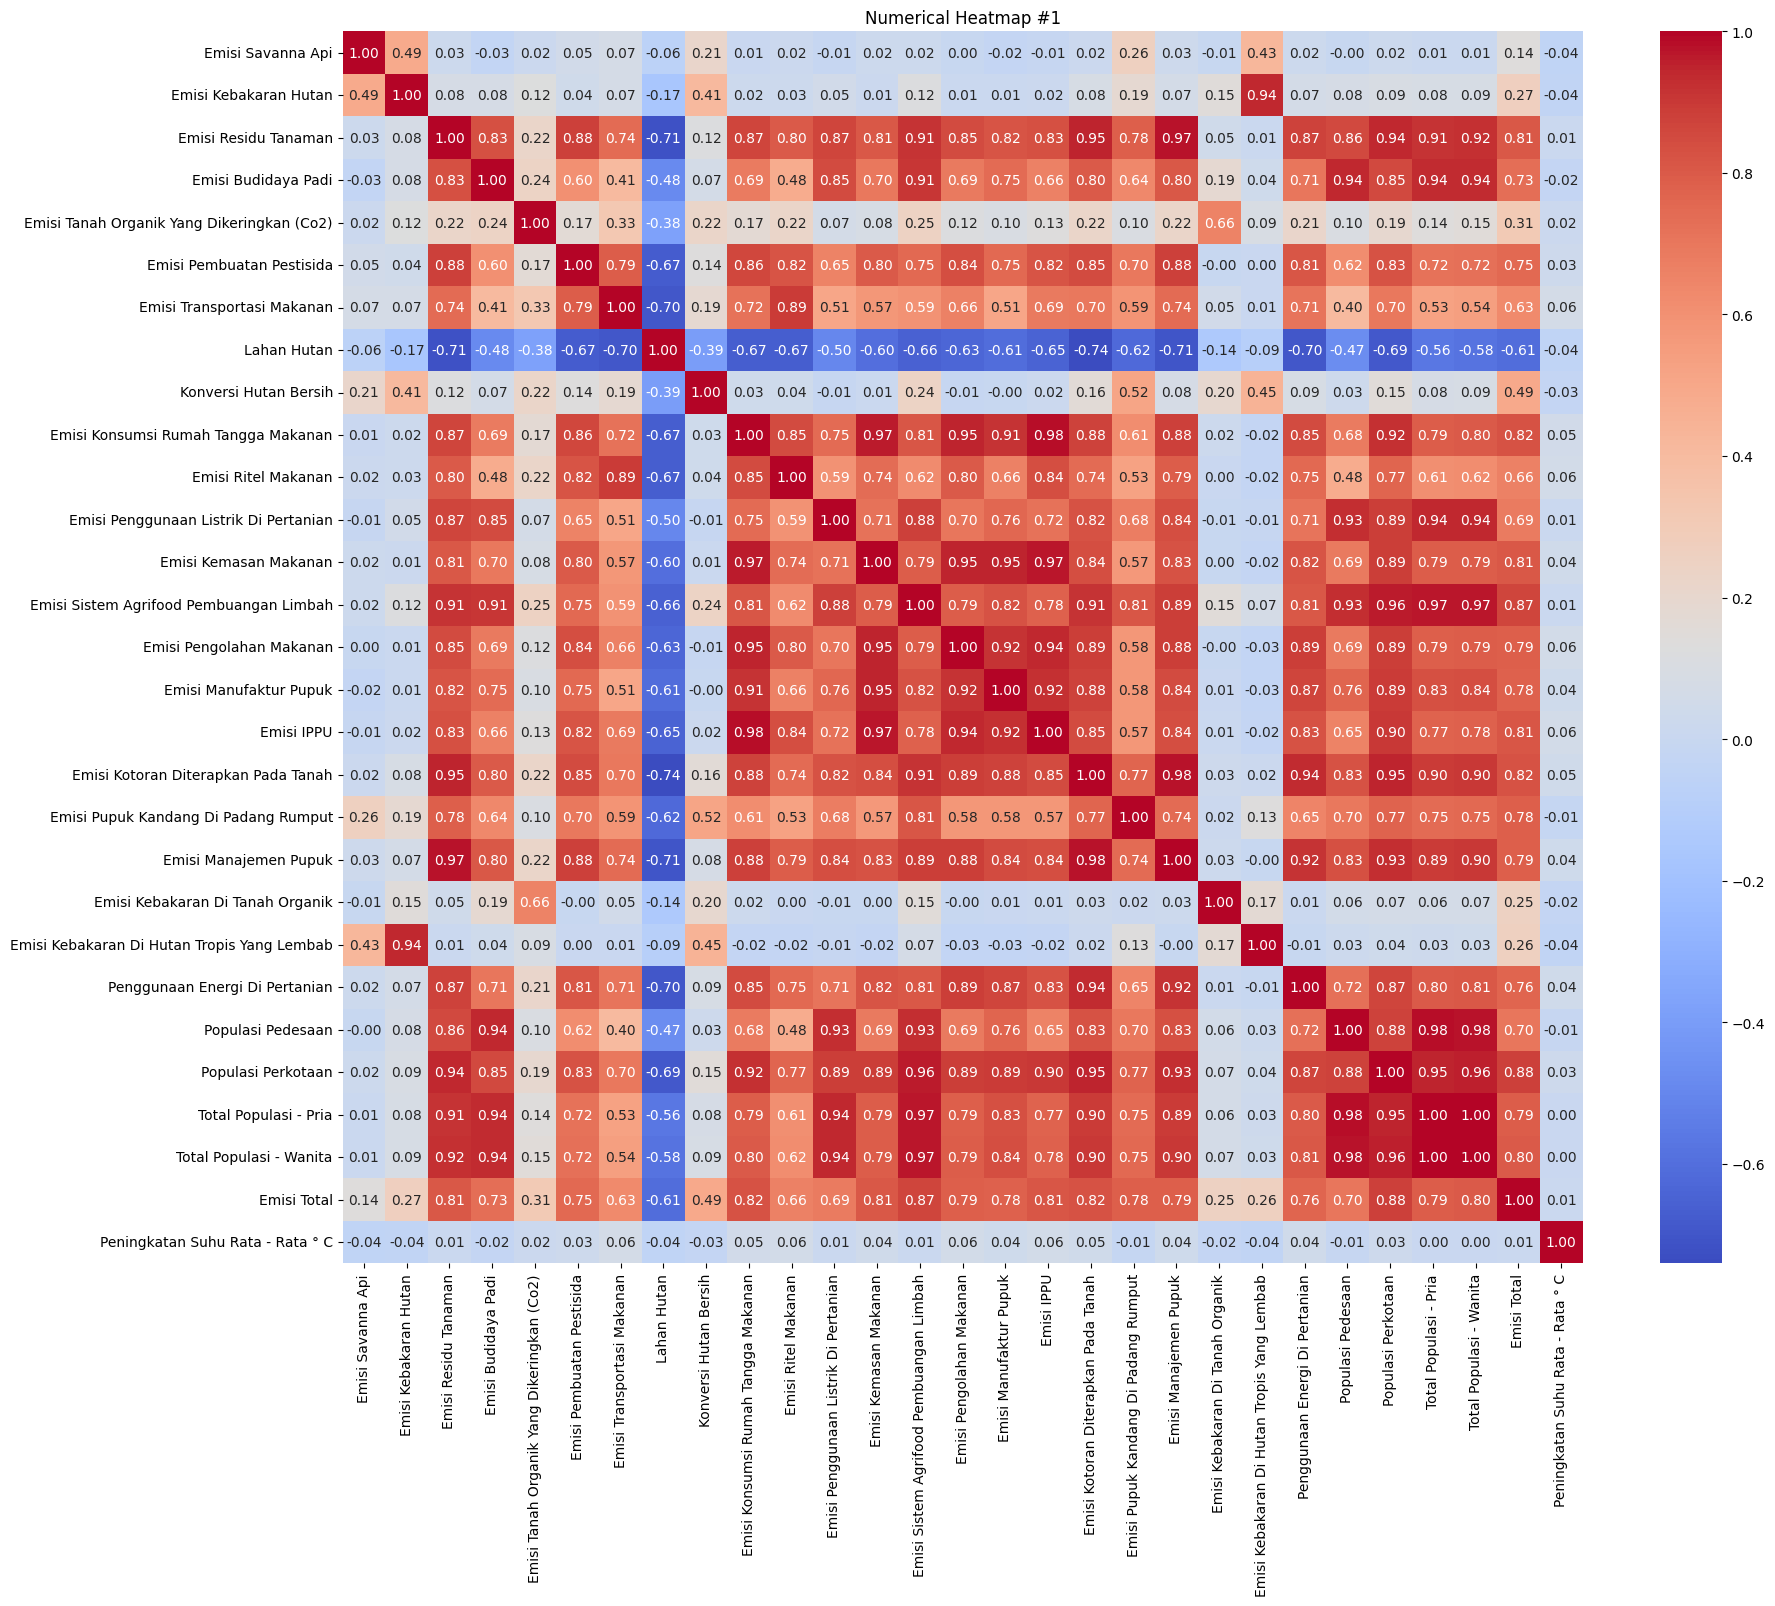

In [87]:
num_corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(20, 16))
sns.heatmap(num_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Heatmap #1")
plt.show()

# Preprocessing #1

## Fix Value

### Lahan Hutan

In [88]:
x['Lahan Hutan'] = abs(x['Lahan Hutan'])
test['Lahan Hutan'] = abs(test['Lahan Hutan'])

## Feature Engineering

### Negara/Tahun > Negara, Tahun

In [89]:
x[['Negara','Tahun']] = x['Negara/Tahun'].apply(lambda x: pd.Series(str(x).split('/')))
test[['Negara','Tahun']] = test['Negara/Tahun'].apply(lambda x: pd.Series(str(x).split('/')))

x['Tahun'] = x['Tahun'].astype(float)
test['Tahun'] = test['Tahun'].astype(float)

x = x.drop('Negara/Tahun',axis=1)
test = test.drop('Negara/Tahun',axis=1)

# EDA #2

In [90]:
numerical = x.select_dtypes(exclude='object').columns.to_list()
categorical = x.select_dtypes(include='object').columns.to_list()

## Categorical Unique Values & Count

In [91]:
for col in categorical:
    print(f"==={col}===")
    print(x[col].unique())
    print()

===Negara===
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belgium-Luxembourg' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Channel Islands' 'Chile' 'China'
 'China, Hong Kong SAR' 'China, Macao SAR' 'China, mainland'
 'China, Taiwan Province of' 'Colombia' 'Comoros' 'Congo' 'Cook Islands'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Czechoslovakia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Est

In [92]:
for col in categorical:
    print(f"==={col}===")
    print(x[col].value_counts())
    print()

===Negara===
Negara
Afghanistan                        25
Isle of Man                        25
Montserrat                         25
Morocco                            25
Mozambique                         25
                                   ..
Ethiopia PDR                        3
South Sudan                         3
USSR                                2
Yugoslav SFR                        2
Pacific Islands Trust Territory     1
Name: count, Length: 236, dtype: int64



## Numerical Heatmap

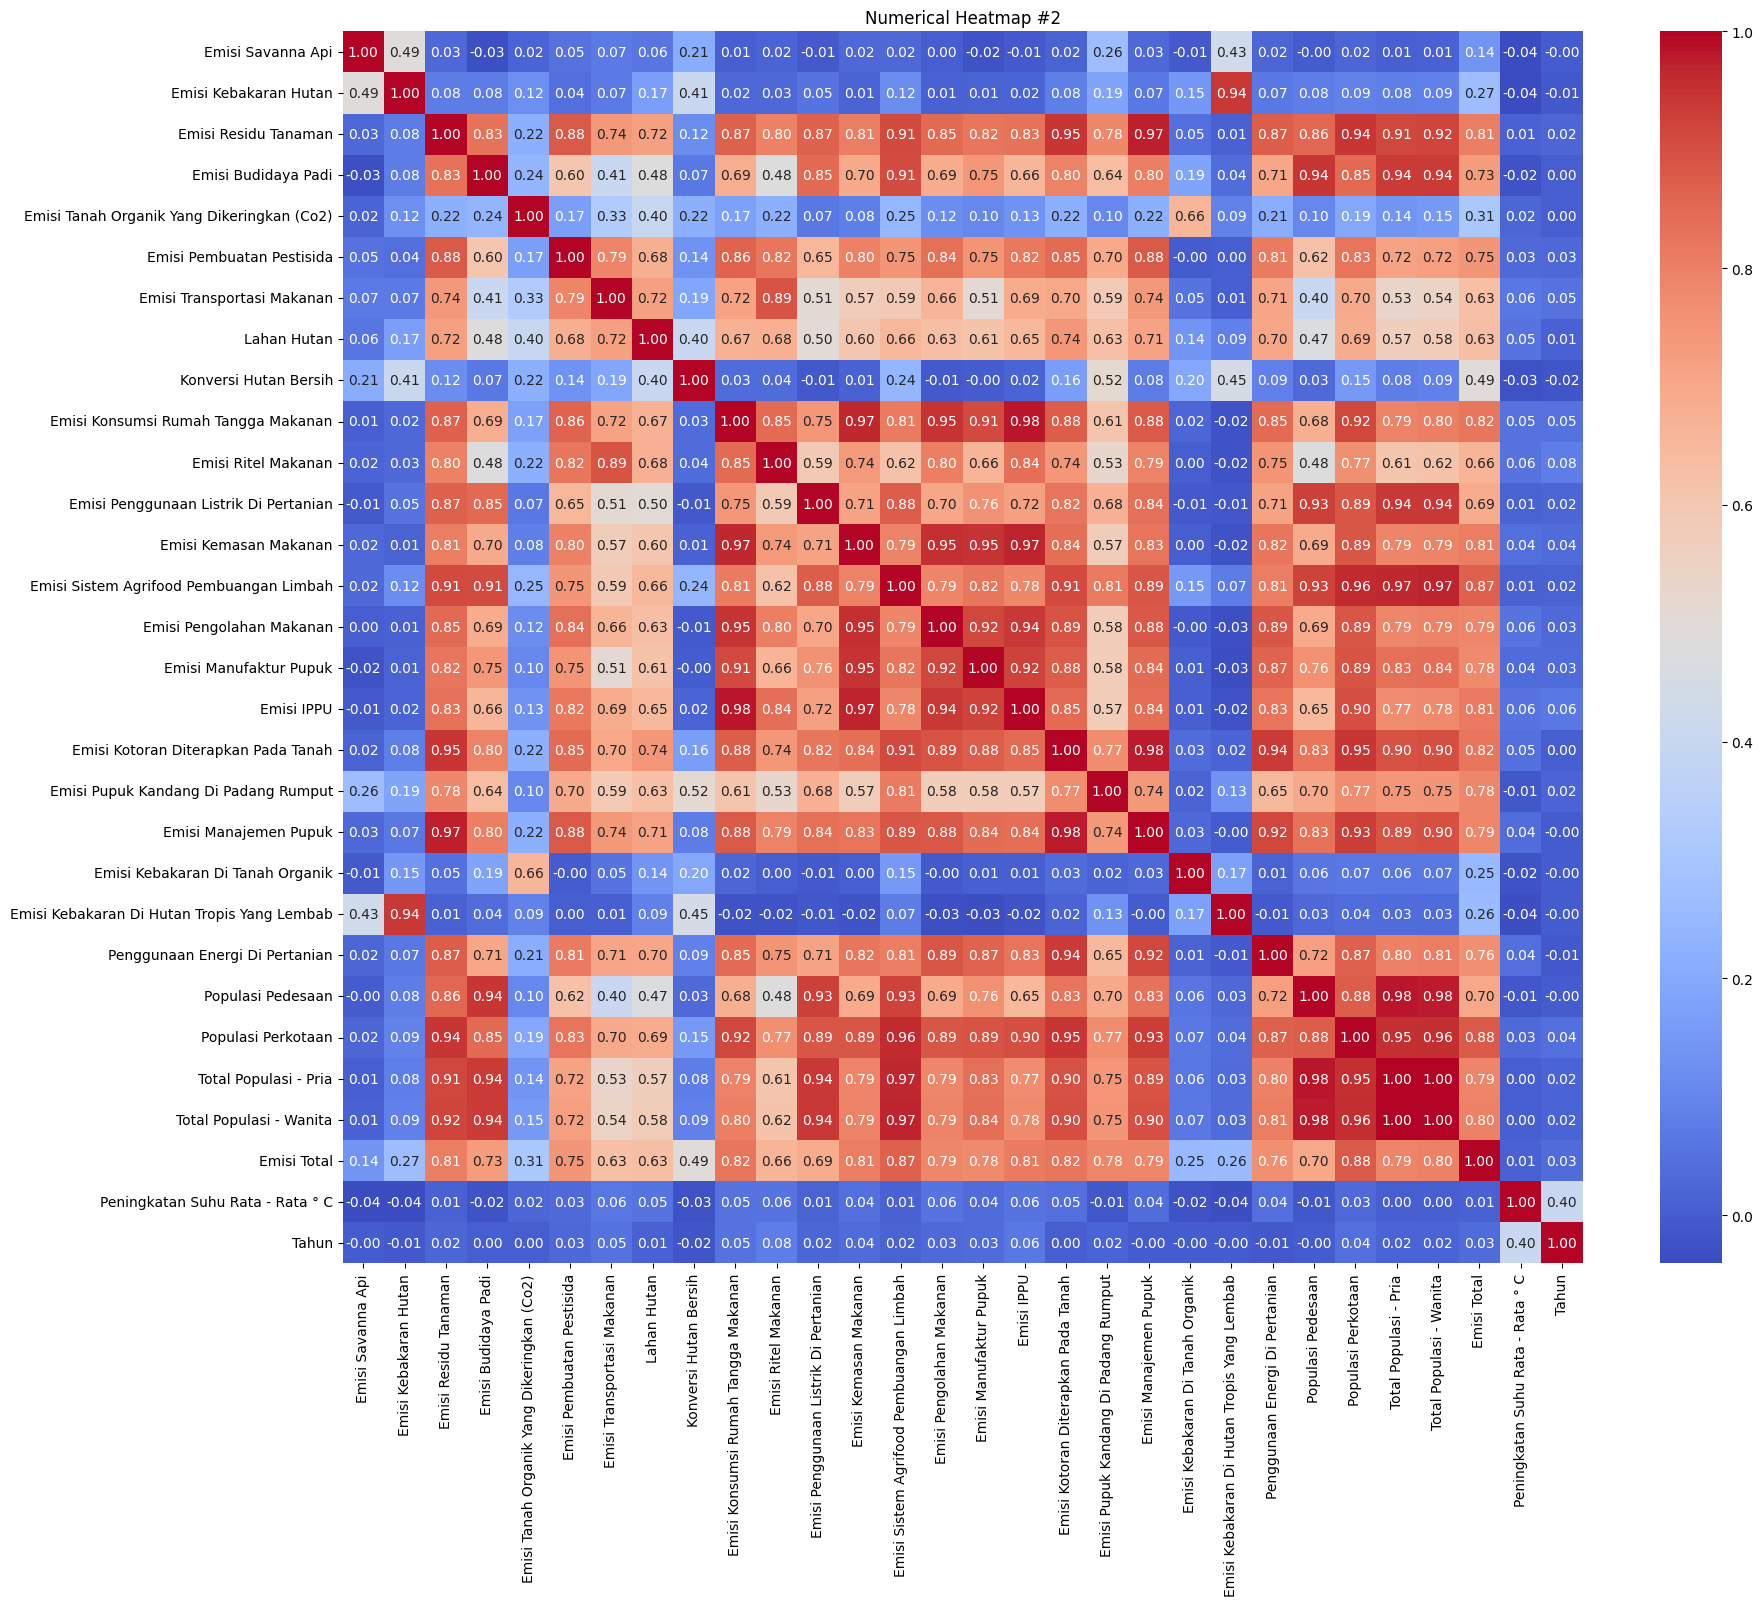

In [93]:
num_corr_matrix = x.corr(numeric_only=True)

plt.figure(figsize=(20, 16))
sns.heatmap(num_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Heatmap #2")
plt.show()

# Preprocessing #2

In [94]:
# NANTI HAPUS
x.head()

Emisi Savanna Api  Emisi Kebakaran Hutan  Emisi Residu Tanaman  \
0            14.7237                 0.0557              205.6077   
1            14.7237                 0.0557              209.4971   
2            14.7237                 0.0557              196.5341   
3            14.7237                 0.0557              230.8175   
4            14.7237                 0.0557              242.0494   

   Emisi Budidaya Padi  Emisi Tanah Organik Yang Dikeringkan (Co2)  \
0               686.00                                         0.0   
1               678.16                                         0.0   
2               686.00                                         0.0   
3               686.00                                         0.0   
4               705.60                                         0.0   

   Emisi Pembuatan Pestisida  Emisi Transportasi Makanan  Lahan Hutan  \
0                  11.807483                     63.1152     2388.803   
1                  11.712073                     61.2125     2388.803   
2                  11.712073                     53.3170     2388.803   
3                  11.712073                     54.3617     2388.803   
4                  11.712073                     53.9874     2388.803   

   Konversi Hutan Bersih  Emisi Konsumsi Rumah Tangga Makanan  \
0                    0.0                              79.0851   
1                    0.0                              80.4885   
2                    0.0                              80.7692   
3                    0.0                              85.0678   
4                    0.0                              88.8058   

   Emisi Ritel Makanan  Emisi Penggunaan Listrik Di Pertanian  \
0             109.6446                                14.2666   
1             116.6789                                11.4182   
2             126.1721                                 9.2752   
3              81.4607                                 9.0635   
4              90.4008                                 8.3962   

   Emisi Kemasan Makanan  Emisi Sistem Agrifood Pembuangan Limbah  \
0              67.631366                                 691.7888   
1              67.631366                                 710.8212   
2              67.631366                                 743.6751   
3              67.631366                                 791.9246   
4              67.631366                                 831.9181   

   Emisi Pengolahan Makanan  Emisi Manufaktur Pupuk  Emisi IPPU  \
0                 252.21419                 11.9970    209.9778   
1                 252.21419                 12.8539    217.0388   
2                 252.21419                 13.4929    222.1156   
3                 252.21419                 14.0559    201.2057   
4                 252.21419                 15.1269    182.2905   

   Emisi Kotoran Diterapkan Pada Tanah  Emisi Pupuk Kandang Di Padang Rumput  \
0                             260.1431                             1590.5319   
1                             268.6292                             1657.2364   
2                             264.7898                             1653.5068   
3                             261.7221                             1642.9623   
4                             267.6219                             1689.3593   

   Emisi Manajemen Pupuk  Emisi Kebakaran Di Tanah Organik  \
0               319.1763                               0.0   
1               342.3079                               0.0   
2               349.1224                               0.0   
3               352.2947                               0.0   
4               367.6784                               0.0   

   Emisi Kebakaran Di Hutan Tropis Yang Lembab  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                       

## Train Test Split

In [95]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4482, 31), (1121, 31), (4482,), (1121,))

## Group By Impute

### List Kolom Impute

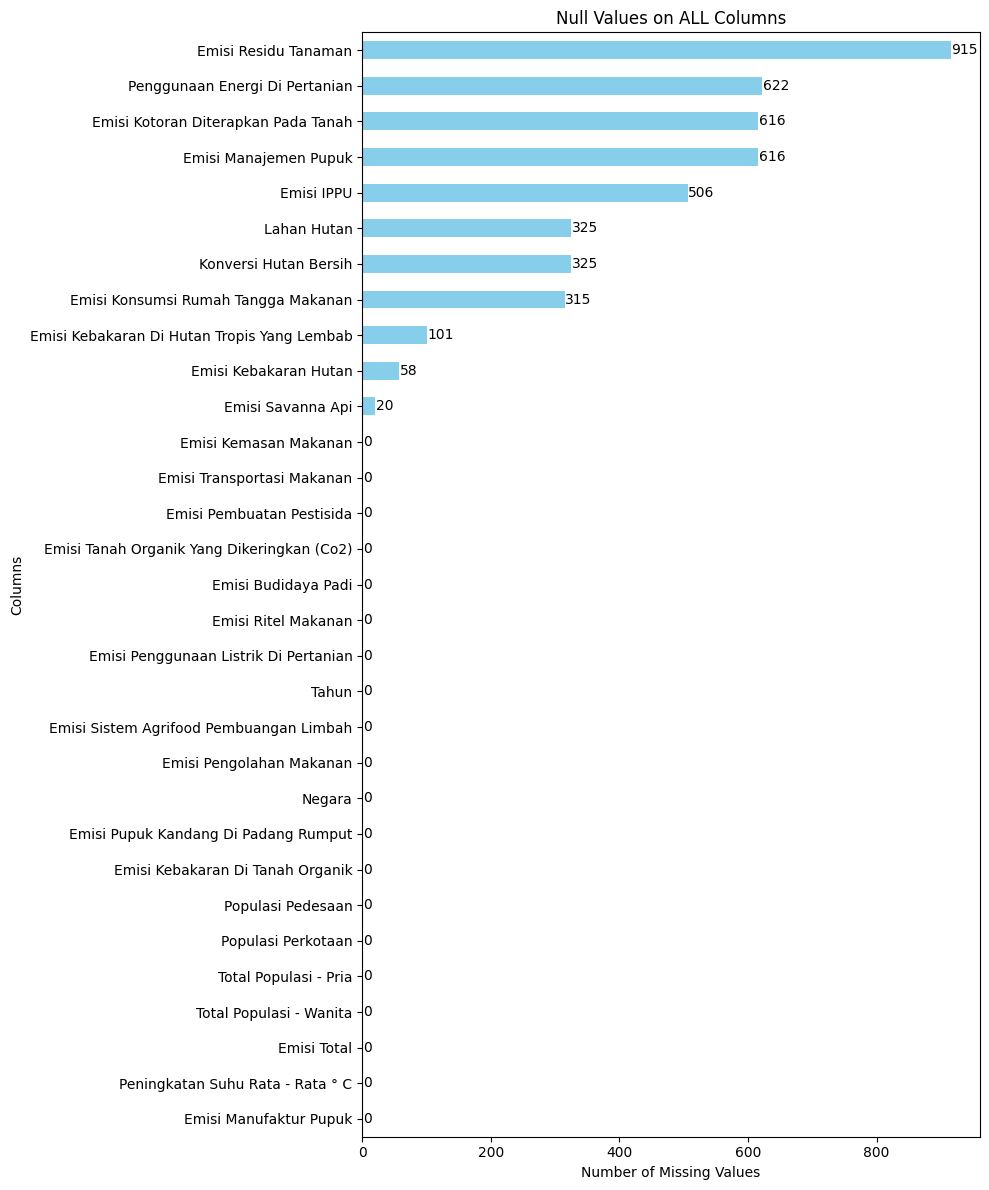

In [96]:
# NANTI HAPUS
def plot_null(null_dtypes, title):
    plt.figure(figsize=(10, 12))
    ax = null_dtypes.plot(kind='barh', color='skyblue')
    plt.title(title)
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    
    for i, (value, name) in enumerate(zip(null_dtypes.values, null_dtypes.index)):
        ax.text(value + 1, i, str(value), va='center')
    
    plt.show()

# UBAH KOLOM (URUTAN CEK > x_train, x_test, x, test)
null_col = x_train.isnull().sum().sort_values(ascending=True)

plot_null(null_col, "Null Values on ALL Columns")

In [97]:
x_train_na = x_train.columns[x_train.isna().any()].tolist()
x_test_na = x_train.columns[x_train.isna().any()].tolist()
x_na = x.columns[x.isna().any()].tolist()
test_na = test.columns[test.isna().any()].tolist()

### USING Negara & Tahun AGREGASI Emisi IMPUTE Emisi

In [98]:
def impute_agg_method_by_skewness(df, col, groupbycol):
    df = df.copy()

    for groupcol, groupval in df.groupby(groupbycol):
        skew_value = skew(groupval[col].dropna())
        if abs(skew_value) < 0.5:
            impute_value = groupval[col].mean()
        else:
            impute_value = groupval[col].median()

        mask = (df[groupbycol] == groupcol) & (df[col].isna())
        df.loc[mask, col] = impute_value

    return df

for col in x_train_na:
    x_train = impute_agg_method_by_skewness(x_train, col, 'Negara')
    x_train = impute_agg_method_by_skewness(x_train, col, 'Tahun')
for col in x_test_na:
    x_test = impute_agg_method_by_skewness(x_test, col, 'Negara')
    x_test = impute_agg_method_by_skewness(x_test, col, 'Tahun')
for col in x_na:
    x = impute_agg_method_by_skewness(x, col, 'Negara')
    x = impute_agg_method_by_skewness(x, col, 'Tahun')
for col in test_na:
    test = impute_agg_method_by_skewness(test, col, 'Negara')
    test = impute_agg_method_by_skewness(test, col, 'Tahun')

## Group By Aggregate

### Grouping Negara, Tahun Agregasi Emisi
- Agregasi **SUM** (Total Emisi per Sektor)

### x_train, x_test

In [99]:
# 1. Mapping kategori tetap
kategori_emisi = {
    # Pertanian
    'Emisi Budidaya Padi': 'Pertanian',
    'Emisi Savanna Api': 'Pertanian',
    'Emisi Kebakaran Hutan': 'Pertanian',
    'Emisi Residu Tanaman': 'Pertanian',
    'Emisi Tanah Organik Yang Dikeringkan (Co2)': 'Pertanian',
    'Emisi Kebakaran Di Tanah Organik': 'Pertanian',
    'Emisi Kebakaran Di Hutan Tropis Yang Lembab': 'Pertanian',
    'Emisi Kotoran Diterapkan Pada Tanah': 'Pertanian',
    'Emisi Pupuk Kandang Di Padang Rumput': 'Pertanian',
    'Emisi Manajemen Pupuk': 'Pertanian',
    
    # Industri
    'Emisi Pembuatan Pestisida': 'Industri',
    'Emisi Manufaktur Pupuk': 'Industri',
    'Emisi IPPU': 'Industri',
    'Emisi Pengolahan Makanan': 'Industri',
    'Emisi Kemasan Makanan': 'Industri',
    
    # Transportasi
    'Emisi Transportasi Makanan': 'Konsumsi',
    'Emisi Konsumsi Rumah Tangga Makanan': 'Konsumsi',
    'Emisi Ritel Makanan': 'Konsumsi',
    
    # Energi
    'Emisi Penggunaan Listrik Di Pertanian': 'Energi',
    'Penggunaan Energi Di Pertanian': 'Energi',
    
    # Limbah
    'Emisi Sistem Agrifood Pembuangan Limbah': 'Limbah',
}

# 2. Long format
emisi_per_kategori_long = x_train.melt(
    id_vars=['Negara', 'Tahun'],
    var_name='Sumber Emisi',
    value_name='Jumlah Emisi'
)

# 3. Tambah kolom kategori
emisi_per_kategori_long['Kategori'] = emisi_per_kategori_long['Sumber Emisi'].map(kategori_emisi)
emisi_per_kategori_long = emisi_per_kategori_long.dropna(subset=['Kategori'])

# 4. Agregasi
sum_per_negara = (
    emisi_per_kategori_long
    .groupby(['Negara', 'Kategori'])['Jumlah Emisi']
    .sum()
    .unstack()
    .add_prefix('Sum_Emisi_')
    .reset_index()
)

mean_per_negara_tahun = (
    emisi_per_kategori_long
    .groupby(['Negara', 'Kategori'])['Jumlah Emisi']
    .mean()
    .unstack()
    .add_prefix('Mean_Emisi_Tahunan_')
    .reset_index()
)

# 5. Merge keduanya agar bisa merge by 'Negara' saja
agg_emisi = mean_per_negara_tahun.merge(sum_per_negara, on='Negara', how='left')

# Merge
x_train = x_train.merge(agg_emisi, how='left', on=['Negara'])
x_test = x_test.merge(agg_emisi, how='left', on=['Negara'])

agg_emisi.head()

Kategori          Negara  Mean_Emisi_Tahunan_Energi  \
0            Afghanistan                  76.322573   
1                Albania                 124.316988   
2                Algeria                 173.676891   
3         American Samoa                  24.961084   
4                Andorra                  39.705476   

Kategori  Mean_Emisi_Tahunan_Industri  Mean_Emisi_Tahunan_Konsumsi  \
0                          167.614976                   183.175368   
1                          336.265140                    97.603714   
2                         1987.912482                  4577.331427   
3                          573.996380                     7.520882   
4                          375.758822                    14.817824   

Kategori  Mean_Emisi_Tahunan_Limbah  Mean_Emisi_Tahunan_Pertanian  \
0                       1549.790118                    414.198429   
1                        538.743229                    150.799948   
2                       7667.416512                    366.204016   
3                          1.992573                    371.820513   
4                         15.036078                    367.744851   

Kategori  Sum_Emisi_Energi  Sum_Emisi_Industri  Sum_Emisi_Konsumsi  \
0              3358.193200        18437.647312          12089.5743   
1              4226.777600        28582.536906           4977.7894   
2              5905.014300       168972.560972         233443.9028   
3              1098.287681        63139.601817            496.3782   
4              1429.397130        33818.294023            800.1625   

Kategori  Sum_Emisi_Limbah  Sum_Emisi_Pertanian  
0               34095.3826         91123.654300  
1                9158.6349         25635.991077  
2              130346.0807         62254.682700  
3                  43.8366         81800.512856  
4                 270.6494         66194.073134

In [100]:
x_train.head()

Emisi Savanna Api  Emisi Kebakaran Hutan  Emisi Residu Tanaman  \
0             0.4985                 0.0000              172.4957   
1          1107.0822              2986.3564              356.2161   
2             0.0000                 0.0000                0.2000   
3          1971.3269              6775.2799              110.2167   
4           929.4387             13814.5201             2060.7349   

   Emisi Budidaya Padi  Emisi Tanah Organik Yang Dikeringkan (Co2)  \
0           624.365142                                      0.0000   
1          8316.089200                                      0.0000   
2           926.342278                                      0.0000   
3           245.025500                                      0.0000   
4         30101.884600                                  14126.2332   

   Emisi Pembuatan Pestisida  Emisi Transportasi Makanan  Lahan Hutan  \
0                  24.000000                  505.692400    1319.6122   
1                  13.626398                  152.409700     607.7215   
2                 252.742028                 2298.021251     356.0556   
3                  20.000000                  236.683600     425.1388   
4                 119.000000                  480.280900     984.4877   

   Konversi Hutan Bersih  Emisi Konsumsi Rumah Tangga Makanan  \
0                11.6084                            1296.1563   
1              4777.0038                             107.7779   
2                37.1448                             151.6280   
3             76739.2436                             430.3613   
4             86304.4354                             490.9926   

   Emisi Ritel Makanan  Emisi Penggunaan Listrik Di Pertanian  \
0           485.920400                             254.416600   
1            57.034500                              24.285117   
2          1266.337019                             643.580231   
3            40.664000                              51.136900   
4           486.039600                             584.745178   

   Emisi Kemasan Makanan  Emisi Sistem Agrifood Pembuangan Limbah  \
0             156.593400                              2671.522500   
1              69.901897                              1412.684900   
2            1186.432655                                89.961068   
3              67.631366                              1291.779800   
4              24.411100                              7690.691800   

   Emisi Pengolahan Makanan  Emisi Manufaktur Pupuk  Emisi IPPU  \
0                190.341100             1186.506200   3086.0292   
1                482.238986              356.491017     32.5258   
2               2369.112862             2012.447178    732.4806   
3                242.332715              216.378000    349.0123   
4                284.627900              290.881300   1154.7232   

   Emisi Kotoran Diterapkan Pada Tanah  Emisi Pupuk Kandang Di Padang Rumput  \
0                             68.81560                           1298.137100   
1                            345.08540                            819.230700   
2                            122.28355                           2148.251693   
3                            184.96670                           3138.565300   
4                           2350.21440                           4905.897900   

   Emisi Manajemen Pupuk  Emisi Kebakaran Di Tanah Organik  \
0               139.0507                             0.000   
1              1301.3498                             0.000   
2               271.3767                             0.000   
3               442.8572                             0.000   
4              8168.7442                          3959.323   

   Emisi Kebakaran Di Hutan Tropis Yang Lembab  \
0                                       0.0000   
1                                    1089.3919   
2                                       0.0000   
3                                    6397.9835   
4                       

### x, test

In [101]:
# 1. Mapping kategori tetap
kategori_emisi = {
    # Pertanian
    'Emisi Budidaya Padi': 'Pertanian',
    'Emisi Savanna Api': 'Pertanian',
    'Emisi Kebakaran Hutan': 'Pertanian',
    'Emisi Residu Tanaman': 'Pertanian',
    'Emisi Tanah Organik Yang Dikeringkan (Co2)': 'Pertanian',
    'Emisi Kebakaran Di Tanah Organik': 'Pertanian',
    'Emisi Kebakaran Di Hutan Tropis Yang Lembab': 'Pertanian',
    'Emisi Kotoran Diterapkan Pada Tanah': 'Pertanian',
    'Emisi Pupuk Kandang Di Padang Rumput': 'Pertanian',
    'Emisi Manajemen Pupuk': 'Pertanian',
    
    # Industri
    'Emisi Pembuatan Pestisida': 'Industri',
    'Emisi Manufaktur Pupuk': 'Industri',
    'Emisi IPPU': 'Industri',
    'Emisi Pengolahan Makanan': 'Industri',
    'Emisi Kemasan Makanan': 'Industri',
    
    # Transportasi
    'Emisi Transportasi Makanan': 'Konsumsi',
    'Emisi Konsumsi Rumah Tangga Makanan': 'Konsumsi',
    'Emisi Ritel Makanan': 'Konsumsi',
    
    # Energi
    'Emisi Penggunaan Listrik Di Pertanian': 'Energi',
    'Penggunaan Energi Di Pertanian': 'Energi',
    
    # Limbah
    'Emisi Sistem Agrifood Pembuangan Limbah': 'Limbah',
}

# 2. Long format
emisi_per_kategori_long = x.melt(
    id_vars=['Negara', 'Tahun'],
    var_name='Sumber Emisi',
    value_name='Jumlah Emisi'
)

# 3. Tambah kolom kategori
emisi_per_kategori_long['Kategori'] = emisi_per_kategori_long['Sumber Emisi'].map(kategori_emisi)
emisi_per_kategori_long = emisi_per_kategori_long.dropna(subset=['Kategori'])

# 4. Agregasi
sum_per_negara = (
    emisi_per_kategori_long
    .groupby(['Negara', 'Kategori'])['Jumlah Emisi']
    .sum()
    .unstack()
    .add_prefix('Sum_Emisi_')
    .reset_index()
)

mean_per_negara_tahun = (
    emisi_per_kategori_long
    .groupby(['Negara', 'Kategori'])['Jumlah Emisi']
    .mean()
    .unstack()
    .add_prefix('Mean_Emisi_Tahunan_')
    .reset_index()
)

# 5. Merge keduanya agar bisa merge by 'Negara' saja
agg_emisi = mean_per_negara_tahun.merge(sum_per_negara, on='Negara', how='left')

# Merge
x = x.merge(agg_emisi, how='left', on=['Negara'])
test = test.merge(agg_emisi, how='left', on=['Negara'])

agg_emisi.head()

Kategori          Negara  Mean_Emisi_Tahunan_Energi  \
0            Afghanistan                  77.769682   
1                Albania                 116.723042   
2                Algeria                 165.475326   
3         American Samoa                  25.131449   
4                Andorra                  39.328945   

Kategori  Mean_Emisi_Tahunan_Industri  Mean_Emisi_Tahunan_Konsumsi  \
0                          160.382353                   176.312517   
1                          315.447483                    92.572013   
2                         1959.001777                  4566.865592   
3                          572.692599                     7.601056   
4                          377.493354                    14.674877   

Kategori  Mean_Emisi_Tahunan_Limbah  Mean_Emisi_Tahunan_Pertanian  \
0                       1537.527240                    411.399861   
1                        535.206196                    151.936383   
2                       7706.533496                    364.005806   
3                          1.996900                    370.234614   
4                         15.040752                    367.938432   

Kategori  Sum_Emisi_Energi  Sum_Emisi_Industri  Sum_Emisi_Konsumsi  \
0               3888.48410        20047.794139          13223.4388   
1               5836.15210        39430.935316           6942.9010   
2               8273.76630       244875.222185         342514.9194   
3               1256.57247        71586.574910            570.0792   
4               1966.44727        47186.669300           1100.6158   

Kategori  Sum_Emisi_Limbah  Sum_Emisi_Pertanian  
0               38438.1810        102849.965300  
1               13380.1549         37984.095837  
2              192663.3374         91001.451400  
3                  49.9225         92558.653380  
4                 376.0188         91984.607987

In [102]:
x.head()

Emisi Savanna Api  Emisi Kebakaran Hutan  Emisi Residu Tanaman  \
0            14.7237                 0.0557              205.6077   
1            14.7237                 0.0557              209.4971   
2            14.7237                 0.0557              196.5341   
3            14.7237                 0.0557              230.8175   
4            14.7237                 0.0557              242.0494   

   Emisi Budidaya Padi  Emisi Tanah Organik Yang Dikeringkan (Co2)  \
0               686.00                                         0.0   
1               678.16                                         0.0   
2               686.00                                         0.0   
3               686.00                                         0.0   
4               705.60                                         0.0   

   Emisi Pembuatan Pestisida  Emisi Transportasi Makanan  Lahan Hutan  \
0                  11.807483                     63.1152     2388.803   
1                  11.712073                     61.2125     2388.803   
2                  11.712073                     53.3170     2388.803   
3                  11.712073                     54.3617     2388.803   
4                  11.712073                     53.9874     2388.803   

   Konversi Hutan Bersih  Emisi Konsumsi Rumah Tangga Makanan  \
0                    0.0                              79.0851   
1                    0.0                              80.4885   
2                    0.0                              80.7692   
3                    0.0                              85.0678   
4                    0.0                              88.8058   

   Emisi Ritel Makanan  Emisi Penggunaan Listrik Di Pertanian  \
0             109.6446                                14.2666   
1             116.6789                                11.4182   
2             126.1721                                 9.2752   
3              81.4607                                 9.0635   
4              90.4008                                 8.3962   

   Emisi Kemasan Makanan  Emisi Sistem Agrifood Pembuangan Limbah  \
0              67.631366                                 691.7888   
1              67.631366                                 710.8212   
2              67.631366                                 743.6751   
3              67.631366                                 791.9246   
4              67.631366                                 831.9181   

   Emisi Pengolahan Makanan  Emisi Manufaktur Pupuk  Emisi IPPU  \
0                 252.21419                 11.9970    209.9778   
1                 252.21419                 12.8539    217.0388   
2                 252.21419                 13.4929    222.1156   
3                 252.21419                 14.0559    201.2057   
4                 252.21419                 15.1269    182.2905   

   Emisi Kotoran Diterapkan Pada Tanah  Emisi Pupuk Kandang Di Padang Rumput  \
0                             260.1431                             1590.5319   
1                             268.6292                             1657.2364   
2                             264.7898                             1653.5068   
3                             261.7221                             1642.9623   
4                             267.6219                             1689.3593   

   Emisi Manajemen Pupuk  Emisi Kebakaran Di Tanah Organik  \
0               319.1763                               0.0   
1               342.3079                               0.0   
2               349.1224                               0.0   
3               352.2947                               0.0   
4               367.6784                               0.0   

   Emisi Kebakaran Di Hutan Tropis Yang Lembab  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                       

## Drop Columns

In [103]:
x_train = x_train.drop('Peningkatan Suhu Rata - Rata ° C', axis=1)
x_test = x_test.drop('Peningkatan Suhu Rata - Rata ° C', axis=1)
x = x.drop("Peningkatan Suhu Rata - Rata ° C", axis=1)

## Reset Index

In [104]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Preprocessing #3

## Feature Selection

In [105]:
# selected = []
# selected = ['Tahun', 'Emisi IPPU', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi Budidaya Padi', 'Lahan Hutan', 'Emisi Kebakaran Hutan', 'Mean_Emisi_Tahunan_Konsumsi', 'Emisi Savanna Api', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi Penggunaan Listrik Di Pertanian', 'Emisi Konsumsi Rumah Tangga Makanan', 'Konversi Hutan Bersih', 'Penggunaan Energi Di Pertanian', 'Emisi Residu Tanaman']
# selected = ['Tahun', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi Budidaya Padi', 'Lahan Hutan', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi IPPU', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Konversi Hutan Bersih', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi Penggunaan Listrik Di Pertanian', 'Mean_Emisi_Tahunan_Energi', 'Sum_Emisi_Pertanian', 'Penggunaan Energi Di Pertanian', 'Emisi Savanna Api', 'Populasi Pedesaan']
selected = ['Tahun', 'Emisi Savanna Api', 'Emisi Budidaya Padi', 'Emisi Pupuk Kandang Di Padang Rumput', 'Lahan Hutan', 'Emisi IPPU', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi Penggunaan Listrik Di Pertanian', 'Konversi Hutan Bersih', 'Mean_Emisi_Tahunan_Energi', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Emisi Residu Tanaman', 'Emisi Kebakaran Hutan', 'Emisi Sistem Agrifood Pembuangan Limbah']
# selected = ['Tahun', 'Emisi Budidaya Padi', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Lahan Hutan', 'Emisi Savanna Api', 'Emisi IPPU', 'Konversi Hutan Bersih', 'Emisi Kotoran Diterapkan Pada Tanah', 'Penggunaan Energi Di Pertanian', 'Emisi Penggunaan Listrik Di Pertanian']


x_train = x_train[selected]
x_test = x_test[selected]

x = x[selected]
test = test[selected]

## Categorical > Numerical

In [106]:
categorical = x.select_dtypes(include='object').columns.to_list()

In [107]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

x_train[categorical] = encoder.fit_transform(x_train[categorical])
x_test[categorical] = encoder.transform(x_test[categorical])

x[categorical] = encoder.fit_transform(x[categorical])
test[categorical] = encoder.transform(test[categorical])

## Impute
- Tidak dibutuhkan karena diatas sudah selesai impute

### Iterative Imputer

In [108]:
# imputer = IterativeImputer(random_state=seed)
# x_train = imputer.fit_transform(x_train)
# x_test = imputer.transform(x_test)
# x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
# x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# x = imputer.fit_transform(x)
# test = imputer.transform(test)

# for col in x.select_dtypes(include='object').columns:
#     x_train[col] = x_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x_test[col] = x_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x[col] = x[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

### KNN Imputer

In [109]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)
# x_train = imputer.fit_transform(x_train)
# x_test = imputer.transform(x_test)
# x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
# x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# x = imputer.fit_transform(x)
# test = imputer.transform(test)

# for col in x.select_dtypes(include='object').columns:
#     x_train[col] = x_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x_test[col] = x_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x[col] = x[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Outlier Handling

In [110]:
numerical = x.select_dtypes(exclude='object').columns.to_list()

### Z-Score

In [111]:
def outlier_to_nan(df, numerical, threshold=3.0):
    df = df.copy()
    for col in numerical:
        z_scores = zscore(df[col])
        df.loc[np.abs(z_scores) > threshold, col] = np.nan
    return df

x_train = outlier_to_nan(x_train, numerical)
x_test = outlier_to_nan(x_test, numerical)
x = outlier_to_nan(x, numerical)
test = outlier_to_nan(test, numerical)

### Quantile

In [112]:
# q1 = train['Emisi Savanna Api'].quantile(0.25)
# q3 = train['Emisi Savanna Api'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Savanna Api'].quantile(0.99)

# train.loc[train['Emisi Savanna Api'] > upper_bound, 'Emisi Savanna Api'] = upper_bound
# # train.loc[train['Emisi Savanna Api'] > upper_cap, 'Emisi Savanna Api'] = upper_cap
# train.loc[train['Emisi Savanna Api'] < lower_bound, 'Emisi Savanna Api'] = lower_bound
# # train['Emisi Savanna Api'] = np.log1p(train['Emisi Kebakaran Hutan'])

# q1 = train['Emisi Kebakaran Hutan'].quantile(0.25)
# q3 = train['Emisi Kebakaran Hutan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Kebakaran Hutan'].quantile(0.99)

# train.loc[train['Emisi Kebakaran Hutan'] > upper_bound, 'Emisi Kebakaran Hutan'] = upper_bound
# # train.loc[train['Emisi Kebakaran Hutan'] > upper_cap, 'Emisi Kebakaran Hutan'] = upper_cap
# train.loc[train['Emisi Kebakaran Hutan'] < lower_bound, 'Emisi Kebakaran Hutan'] = lower_bound
# # train['Emisi Kebakaran Hutan'] = np.log1p(train['Emisi Kebakaran Hutan'])

# q1 = train['Emisi Residu Tanaman'].quantile(0.25)
# q3 = train['Emisi Residu Tanaman'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Residu Tanaman'].quantile(0.99)

# train.loc[train['Emisi Residu Tanaman'] > upper_bound, 'Emisi Residu Tanaman'] = upper_bound
# # train.loc[train['Emisi Residu Tanaman'] > upper_cap, 'Emisi Residu Tanaman'] = upper_cap
# train.loc[train['Emisi Residu Tanaman'] < lower_bound, 'Emisi Residu Tanaman'] = lower_bound
# # train['Emisi Residu Tanaman'] = np.log1p(train['Emisi Residu Tanaman'])

# q1 = train['Emisi Tanah Organik Yang Dikeringkan (Co2)'].quantile(0.25)
# q3 = train['Emisi Tanah Organik Yang Dikeringkan (Co2)'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Tanah Organik Yang Dikeringkan (Co2)'].quantile(0.99)

# train.loc[train['Emisi Tanah Organik Yang Dikeringkan (Co2)'] > upper_bound, 'Emisi Tanah Organik Yang Dikeringkan (Co2)'] = upper_bound
# # train.loc[train['Emisi Tanah Organik Yang Dikeringkan (Co2)'] > upper_cap, 'Emisi Tanah Organik Yang Dikeringkan (Co2)'] = upper_cap
# train.loc[train['Emisi Tanah Organik Yang Dikeringkan (Co2)'] < lower_bound, 'Emisi Tanah Organik Yang Dikeringkan (Co2)'] = lower_bound
# # # train['Emisi Tanah Organik Yang Dikeringkan (Co2)'] = np.log1p(train['Emisi Tanah Organik Yang Dikeringkan (Co2)'])

# q1 = train['Emisi Pembuatan Pestisida'].quantile(0.25)
# q3 = train['Emisi Pembuatan Pestisida'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Pembuatan Pestisida'].quantile(0.99)

# train.loc[train['Emisi Pembuatan Pestisida'] > upper_bound, 'Emisi Pembuatan Pestisida'] = upper_bound
# # train.loc[train['Emisi Pembuatan Pestisida'] > upper_cap, 'Emisi Pembuatan Pestisida'] = upper_cap
# train.loc[train['Emisi Pembuatan Pestisida'] < lower_bound, 'Emisi Pembuatan Pestisida'] = lower_bound
# # train['Emisi Pembuatan Pestisida'] = np.log1p(train['Emisi Pembuatan Pestisida'])

# q1 = train['Emisi Transportasi Makanan'].quantile(0.25)
# q3 = train['Emisi Transportasi Makanan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Transportasi Makanan'].quantile(0.99)

# train.loc[train['Emisi Transportasi Makanan'] > upper_bound, 'Emisi Transportasi Makanan'] = upper_bound
# # train.loc[train['Emisi Transportasi Makanan'] > upper_cap, 'Emisi Transportasi Makanan'] = upper_cap
# train.loc[train['Emisi Transportasi Makanan'] < lower_bound, 'Emisi Transportasi Makanan'] = lower_bound
# # train['Emisi Transportasi Makanan'] = np.log1p(train['Emisi Transportasi Makanan'])

# q1 = train['Lahan Hutan'].quantile(0.25)
# q3 = train['Lahan Hutan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Lahan Hutan'].quantile(0.99)

# train.loc[train['Lahan Hutan'] > upper_bound, 'Lahan Hutan'] = upper_bound
# # train.loc[train['Lahan Hutan'] > upper_cap, 'Lahan Hutan'] = upper_cap
# train.loc[train['Lahan Hutan'] < lower_bound, 'Lahan Hutan'] = lower_bound
# # train['Lahan Hutan'] = np.log1p(train['Lahan Hutan'])

# q1 = train['Konversi Hutan Bersih'].quantile(0.25)
# q3 = train['Konversi Hutan Bersih'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Konversi Hutan Bersih'].quantile(0.99)

# train.loc[train['Konversi Hutan Bersih'] > upper_bound, 'Konversi Hutan Bersih'] = upper_bound
# # train.loc[train['Konversi Hutan Bersih'] > upper_cap, 'Konversi Hutan Bersih'] = upper_cap
# train.loc[train['Konversi Hutan Bersih'] < lower_bound, 'Konversi Hutan Bersih'] = lower_bound
# # train['Konversi Hutan Bersih'] = np.log1p(train['Konversi Hutan Bersih'])

# q1 = train['Emisi Konsumsi Rumah Tangga Makanan'].quantile(0.25)
# q3 = train['Emisi Konsumsi Rumah Tangga Makanan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Konsumsi Rumah Tangga Makanan'].quantile(0.99)

# train.loc[train['Emisi Konsumsi Rumah Tangga Makanan'] > upper_bound, 'Emisi Konsumsi Rumah Tangga Makanan'] = upper_bound
# # train.loc[train['Emisi Konsumsi Rumah Tangga Makanan'] > upper_cap, 'Emisi Konsumsi Rumah Tangga Makanan'] = upper_cap
# train.loc[train['Emisi Konsumsi Rumah Tangga Makanan'] < lower_bound, 'Emisi Konsumsi Rumah Tangga Makanan'] = lower_bound
# # train['Emisi Konsumsi Rumah Tangga Makanan'] = np.log1p(train['Emisi Konsumsi Rumah Tangga Makanan'])

# q1 = train['Emisi Ritel Makanan'].quantile(0.25)
# q3 = train['Emisi Ritel Makanan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Ritel Makanan'].quantile(0.99)

# train.loc[train['Emisi Ritel Makanan'] > upper_bound, 'Emisi Ritel Makanan'] = upper_bound
# # train.loc[train['Emisi Ritel Makanan'] > upper_cap, 'Emisi Ritel Makanan'] = upper_cap
# train.loc[train['Emisi Ritel Makanan'] < lower_bound, 'Emisi Ritel Makanan'] = lower_bound
# # train['Emisi Ritel Makanan'] = np.log1p(train['Emisi Ritel Makanan'])

# q1 = train['Emisi Penggunaan Listrik Di Pertanian'].quantile(0.25)
# q3 = train['Emisi Penggunaan Listrik Di Pertanian'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Penggunaan Listrik Di Pertanian'].quantile(0.99)

# train.loc[train['Emisi Penggunaan Listrik Di Pertanian'] > upper_bound, 'Emisi Penggunaan Listrik Di Pertanian'] = upper_bound
# # train.loc[train['Emisi Penggunaan Listrik Di Pertanian'] > upper_cap, 'Emisi Penggunaan Listrik Di Pertanian'] = upper_cap
# train.loc[train['Emisi Penggunaan Listrik Di Pertanian'] < lower_bound, 'Emisi Penggunaan Listrik Di Pertanian'] = lower_bound
# # train['Emisi Penggunaan Listrik Di Pertanian'] = np.log1p(train['Emisi Penggunaan Listrik Di Pertanian'])

# q1 = train['Emisi Kemasan Makanan'].quantile(0.25)
# q3 = train['Emisi Kemasan Makanan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Kemasan Makanan'].quantile(0.99)

# train.loc[train['Emisi Kemasan Makanan'] > upper_bound, 'Emisi Kemasan Makanan'] = upper_bound
# # train.loc[train['Emisi Kemasan Makanan'] > upper_cap, 'Emisi Kemasan Makanan'] = upper_cap
# train.loc[train['Emisi Kemasan Makanan'] < lower_bound, 'Emisi Kemasan Makanan'] = lower_bound
# # train['Emisi Kemasan Makanan'] = np.log1p(train['Emisi Kemasan Makanan'])

# q1 = train['Emisi Sistem Agrifood Pembuangan Limbah'].quantile(0.25)
# q3 = train['Emisi Sistem Agrifood Pembuangan Limbah'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Sistem Agrifood Pembuangan Limbah'].quantile(0.99)

# train.loc[train['Emisi Sistem Agrifood Pembuangan Limbah'] > upper_bound, 'Emisi Sistem Agrifood Pembuangan Limbah'] = upper_bound
# # train.loc[train['Emisi Sistem Agrifood Pembuangan Limbah'] > upper_cap, 'Emisi Sistem Agrifood Pembuangan Limbah'] = upper_cap
# train.loc[train['Emisi Sistem Agrifood Pembuangan Limbah'] < lower_bound, 'Emisi Sistem Agrifood Pembuangan Limbah'] = lower_bound
# # train['Emisi Sistem Agrifood Pembuangan Limbah'] = np.log1p(train['Emisi Sistem Agrifood Pembuangan Limbah'])

# q1 = train['Emisi Pengolahan Makanan'].quantile(0.25)
# q3 = train['Emisi Pengolahan Makanan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Pengolahan Makanan'].quantile(0.99)

# train.loc[train['Emisi Pengolahan Makanan'] > upper_bound, 'Emisi Pengolahan Makanan'] = upper_bound
# # train.loc[train['Emisi Pengolahan Makanan'] > upper_cap, 'Emisi Pengolahan Makanan'] = upper_cap
# train.loc[train['Emisi Pengolahan Makanan'] < lower_bound, 'Emisi Pengolahan Makanan'] = lower_bound
# # train['Emisi Pengolahan Makanan'] = np.log1p(train['Emisi Pengolahan Makanan'])

# q1 = train['Emisi Manufaktur Pupuk'].quantile(0.25)
# q3 = train['Emisi Manufaktur Pupuk'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Manufaktur Pupuk'].quantile(0.99)

# train.loc[train['Emisi Manufaktur Pupuk'] > upper_bound, 'Emisi Manufaktur Pupuk'] = upper_bound
# # train.loc[train['Emisi Manufaktur Pupuk'] > upper_cap, 'Emisi Manufaktur Pupuk'] = upper_cap
# train.loc[train['Emisi Manufaktur Pupuk'] < lower_bound, 'Emisi Manufaktur Pupuk'] = lower_bound
# # train['Emisi Manufaktur Pupuk'] = np.log1p(train['Emisi Manufaktur Pupuk'])

# q1 = train['Emisi IPPU'].quantile(0.25)
# q3 = train['Emisi IPPU'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi IPPU'].quantile(0.99)

# train.loc[train['Emisi IPPU'] > upper_bound, 'Emisi IPPU'] = upper_bound
# # train.loc[train['Emisi IPPU'] > upper_cap, 'Emisi IPPU'] = upper_cap
# train.loc[train['Emisi IPPU'] < lower_bound, 'Emisi IPPU'] = lower_bound
# # train['Emisi IPPU'] = np.log1p(train['Emisi IPPU'])

# q1 = train['Emisi Kotoran Diterapkan Pada Tanah'].quantile(0.25)
# q3 = train['Emisi Kotoran Diterapkan Pada Tanah'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Kotoran Diterapkan Pada Tanah'].quantile(0.99)

# train.loc[train['Emisi Kotoran Diterapkan Pada Tanah'] > upper_bound, 'Emisi Kotoran Diterapkan Pada Tanah'] = upper_bound
# # train.loc[train['Emisi Kotoran Diterapkan Pada Tanah'] > upper_cap, 'Emisi Kotoran Diterapkan Pada Tanah'] = upper_cap
# train.loc[train['Emisi Kotoran Diterapkan Pada Tanah'] < lower_bound, 'Emisi Kotoran Diterapkan Pada Tanah'] = lower_bound
# # train['Emisi Kotoran Diterapkan Pada Tanah'] = np.log1p(train['Emisi Kotoran Diterapkan Pada Tanah'])

# q1 = train['Emisi Pupuk Kandang Di Padang Rumput'].quantile(0.25)
# q3 = train['Emisi Pupuk Kandang Di Padang Rumput'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Pupuk Kandang Di Padang Rumput'].quantile(0.99)

# train.loc[train['Emisi Pupuk Kandang Di Padang Rumput'] > upper_bound, 'Emisi Pupuk Kandang Di Padang Rumput'] = upper_bound
# # train.loc[train['Emisi Pupuk Kandang Di Padang Rumput'] > upper_cap, 'Emisi Pupuk Kandang Di Padang Rumput'] = upper_cap
# train.loc[train['Emisi Pupuk Kandang Di Padang Rumput'] < lower_bound, 'Emisi Pupuk Kandang Di Padang Rumput'] = lower_bound
# # train['Emisi Pupuk Kandang Di Padang Rumput'] = np.log1p(train['Emisi Pupuk Kandang Di Padang Rumput'])

# q1 = train['Emisi Manajemen Pupuk'].quantile(0.25)
# q3 = train['Emisi Manajemen Pupuk'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Manajemen Pupuk'].quantile(0.99)

# train.loc[train['Emisi Manajemen Pupuk'] > upper_bound, 'Emisi Manajemen Pupuk'] = upper_bound
# # train.loc[train['Emisi Manajemen Pupuk'] > upper_cap, 'Emisi Manajemen Pupuk'] = upper_cap
# train.loc[train['Emisi Manajemen Pupuk'] < lower_bound, 'Emisi Manajemen Pupuk'] = lower_bound
# # train['Emisi Manajemen Pupuk'] = np.log1p(train['Emisi Manajemen Pupuk'])

# train.loc[train['Emisi Kebakaran Di Tanah Organik'] > 0.05815, 'Emisi Kebakaran Di Tanah Organik'] = 0.05815

# q1 = train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'].quantile(0.25)
# q3 = train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'].quantile(0.99)

# train.loc[train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'] > upper_bound, 'Emisi Kebakaran Di Hutan Tropis Yang Lembab'] = upper_bound
# # train.loc[train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'] > upper_cap, 'Emisi Kebakaran Di Hutan Tropis Yang Lembab'] = upper_cap
# train.loc[train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'] < lower_bound, 'Emisi Kebakaran Di Hutan Tropis Yang Lembab'] = lower_bound
# # train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'] = np.log1p(train['Emisi Kebakaran Di Hutan Tropis Yang Lembab'])

# q1 = train['Penggunaan Energi Di Pertanian'].quantile(0.25)
# q3 = train['Penggunaan Energi Di Pertanian'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Penggunaan Energi Di Pertanian'].quantile(0.99)

# train.loc[train['Penggunaan Energi Di Pertanian'] > upper_bound, 'Penggunaan Energi Di Pertanian'] = upper_bound
# # train.loc[train['Penggunaan Energi Di Pertanian'] > upper_cap, 'Penggunaan Energi Di Pertanian'] = upper_cap
# train.loc[train['Penggunaan Energi Di Pertanian'] < lower_bound, 'Penggunaan Energi Di Pertanian'] = lower_bound
# # train['Penggunaan Energi Di Pertanian'] = np.log1p(train['Penggunaan Energi Di Pertanian'])

# q1 = train['Populasi Pedesaan'].quantile(0.25)
# q3 = train['Populasi Pedesaan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Populasi Pedesaan'].quantile(0.99)

# train.loc[train['Populasi Pedesaan'] > upper_bound, 'Populasi Pedesaan'] = upper_bound
# # train.loc[train['Populasi Pedesaan'] > upper_cap, 'Populasi Pedesaan'] = upper_cap
# train.loc[train['Populasi Pedesaan'] < lower_bound, 'Populasi Pedesaan'] = lower_bound
# # train['Populasi Pedesaan'] = np.log1p(train['Populasi Pedesaan'])

# q1 = train['Populasi Perkotaan'].quantile(0.25)
# q3 = train['Populasi Perkotaan'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Populasi Perkotaan'].quantile(0.99)

# train.loc[train['Populasi Perkotaan'] > upper_bound, 'Populasi Perkotaan'] = upper_bound
# # train.loc[train['Populasi Perkotaan'] > upper_cap, 'Populasi Perkotaan'] = upper_cap
# train.loc[train['Populasi Perkotaan'] < lower_bound, 'Populasi Perkotaan'] = lower_bound
# # train['Populasi Perkotaan'] = np.log1p(train['Populasi Perkotaan'])

# q1 = train['Emisi Total'].quantile(0.25)
# q3 = train['Emisi Total'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Emisi Total'].quantile(0.99)

# train.loc[train['Emisi Total'] < 0, 'Emisi Total'] = 0
# train.loc[train['Emisi Total'] > upper_bound, 'Emisi Total'] = upper_bound
# # train.loc[train['Emisi Total'] > upper_cap, 'Emisi Total'] = upper_cap
# train.loc[train['Emisi Total'] < lower_bound, 'Emisi Total'] = lower_bound
# # train['Emisi Total'] = np.log1p(train['Emisi Total'])

# q1 = train['Total Populasi'].quantile(0.25)
# q3 = train['Total Populasi'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr
# lower_bound = q1 - 1.5 * iqr
# upper_cap = train['Total Populasi'].quantile(0.99)

# train.loc[train['Total Populasi'] > upper_bound, 'Total Populasi'] = upper_bound
# # train.loc[train['Total Populasi'] > upper_cap, 'Total Populasi'] = upper_cap
# train.loc[train['Total Populasi'] < lower_bound, 'Total Populasi'] = lower_bound
# # train['Total Populasi'] = np.log1p(train['Total Populasi'])

# # q1 = train['Rasio Perkotaan / Total'].quantile(0.25)
# # q3 = train['Rasio Perkotaan / Total'].quantile(0.75)
# # iqr = q3 - q1
# # upper_bound = q3 + 1.5 * iqr
# # lower_bound = q1 - 1.5 * iqr
# # upper_cap = train['Rasio Perkotaan / Total'].quantile(0.99)

# # train.loc[train['Rasio Perkotaan / Total'] > upper_bound, 'Rasio Perkotaan / Total'] = upper_bound
# # # train.loc[train['Populasi Pedesaan'] > upper_cap, 'Populasi Pedesaan'] = upper_cap
# # train.loc[train['Rasio Perkotaan / Total'] < lower_bound, 'Rasio Perkotaan / Total'] = lower_bound
# # # train['Populasi Pedesaan'] = np.log1p(train['Populasi Pedesaan'])

# # q1 = train['Rasio Pedesaan / Total'].quantile(0.25)
# # q3 = train['Rasio Pedesaan / Total'].quantile(0.75)
# # iqr = q3 - q1
# # upper_bound = q3 + 1.5 * iqr
# # lower_bound = q1 - 1.5 * iqr
# # upper_cap = train['Rasio Pedesaan / Total'].quantile(0.99)

# # train.loc[train['Rasio Pedesaan / Total'] > upper_bound, 'Rasio Pedesaan / Total'] = upper_bound
# # # train.loc[train['Populasi Perkotaan'] > upper_cap, 'Populasi Perkotaan'] = upper_cap
# # train.loc[train['Rasio Pedesaan / Total'] < lower_bound, 'Rasio Pedesaan / Total'] = lower_bound
# # # train['Populasi Perkotaan'] = np.log1p(train['Populasi Perkotaan'])

## Impute (After Outlier Z-Score)

### Iterative Imputer

In [113]:
imputer = IterativeImputer(random_state=seed)
# x_train = imputer.fit_transform(x_train)
# x_test = imputer.transform(x_test)
x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# x = imputer.fit_transform(x)
# test = imputer.transform(test)
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)

for col in x.select_dtypes(include='object').columns:
    x_train[col] = x_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    x_test[col] = x_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    x[col] = x[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

### KNN Imputer

In [114]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)
# x_train = imputer.fit_transform(x_train)
# x_test = imputer.transform(x_test)
# x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
# x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# x = imputer.fit_transform(x)
# test = imputer.transform(test)

# for col in x.select_dtypes(include='object').columns:
#     x_train[col] = x_train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x_test[col] = x_test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     x[col] = x[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
#     test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Scaling

In [115]:
scaler = RobustScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

# Model Building & Evaluation

In [116]:
def train(model):
    cv = KFold(n_splits=10, shuffle=True, random_state=seed)
    scores = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_percentage_error')

    scores = -scores

    print(f'CV MAPE Scores: {scores}')
    print(f'Mean CV MAPE: {np.mean(scores):.4f}')
    print(f'Std Deviation: {np.std(scores):.4f}')

In [117]:
def plot_shap(model, selected=15):
    explainer = shap.TreeExplainer(model)
    shap_val = explainer.shap_values(x_test)
    mean_val = np.abs(shap_val).mean(axis=0)

    top_feat_i = np.argsort(mean_val).flatten()[-selected:][::-1]

    top_feat = x_test.columns[top_feat_i]
    
    shap.summary_plot(shap_val, x_test, feature_names=x_test.columns, max_display=x_test.shape[1])

    print(list(top_feat))

## XGB

In [118]:
xgb = XGBRegressor(random_state=seed)

xgb.fit(x_train, y_train)

train(xgb)

y_pred = xgb.predict(x_test)

mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_score:.4f}")

CV MAPE Scores: [1.84176727 1.41421912 1.44724155 0.73109483 0.72430151 0.71261181
 1.08594282 0.96006535 1.20472795 1.35713967]
Mean CV MAPE: 1.1479
Std Deviation: 0.3565
MAPE: 1.2923


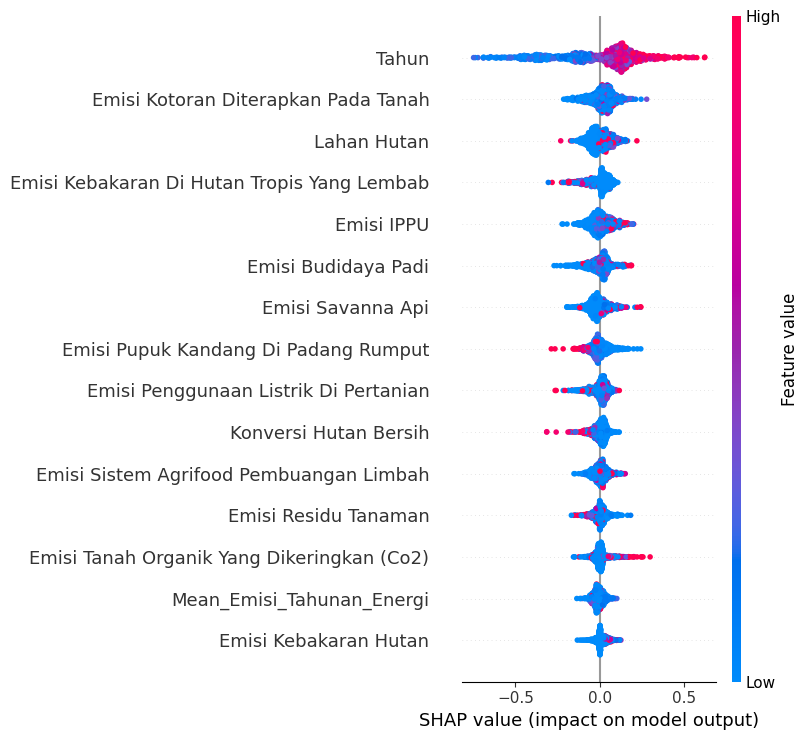

['Tahun', 'Emisi Kotoran Diterapkan Pada Tanah', 'Lahan Hutan', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi IPPU', 'Emisi Budidaya Padi', 'Emisi Savanna Api', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi Penggunaan Listrik Di Pertanian', 'Konversi Hutan Bersih', 'Emisi Sistem Agrifood Pembuangan Limbah', 'Emisi Residu Tanaman', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Mean_Emisi_Tahunan_Energi', 'Emisi Kebakaran Hutan']


In [119]:
plot_shap(xgb)

## LGB

In [120]:
lgb = LGBMRegressor(verbose=0, random_state=seed)

lgb.fit(x_train, y_train)

train(lgb)

y_pred = lgb.predict(x_test)

mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
CV MAPE Scores: [1.62571731 0.90816461 1.49545038 0.72475825 0.75366411 0.71952611
 1.11412462 0.88371466 1.23622284 1.4

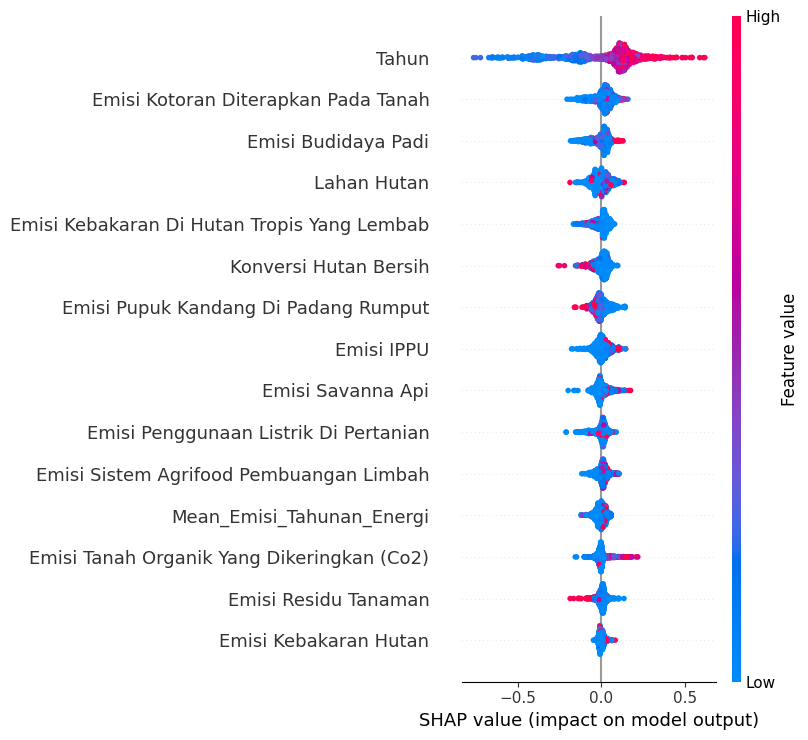

['Tahun', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi Budidaya Padi', 'Lahan Hutan', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Konversi Hutan Bersih', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi IPPU', 'Emisi Savanna Api', 'Emisi Penggunaan Listrik Di Pertanian', 'Emisi Sistem Agrifood Pembuangan Limbah', 'Mean_Emisi_Tahunan_Energi', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Emisi Residu Tanaman', 'Emisi Kebakaran Hutan']


In [121]:
plot_shap(lgb)

# Model Tuning / Hyperparameter Optimization

## XGB Optuna

In [122]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "random_state": seed
    }

    model = XGBRegressor(**params)
    model.fit(x_train, y_train)

    preds = model.predict(x_test)

    mape = mean_absolute_percentage_error(y_test, preds)
    return mape

In [123]:
study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

print(f'Best MAPE: {study_xgb.best_value}')
print(f'Best Params: {study_xgb.best_params}')

  0%|          | 0/100 [00:00<?, ?it/s]

Best MAPE: 1.0719479367739126
Best Params: {'n_estimators': 530, 'max_depth': 3, 'learning_rate': 0.07566013427609634, 'subsample': 0.6565519038283261, 'colsample_bytree': 0.7814121657571637, 'min_child_weight': 6, 'gamma': 0.11630342543884133, 'reg_alpha': 1.2877871394482792, 'reg_lambda': 2.7690298808138674, 'colsample_bylevel': 0.53571853700499, 'colsample_bynode': 0.7152298237688549}


In [124]:
best_model_xgb = XGBRegressor(**study_xgb.best_params, random_state=seed)

best_model_xgb.fit(x_train, y_train)

train(best_model_xgb)

y_pred = best_model_xgb.predict(x_test)

mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_score:.4f}")

CV MAPE Scores: [1.33708642 1.17406276 1.62160735 0.84237562 0.81901469 0.79035167
 1.15271628 1.06355076 1.28304312 1.54439443]
Mean CV MAPE: 1.1628
Std Deviation: 0.2776
MAPE: 1.0719


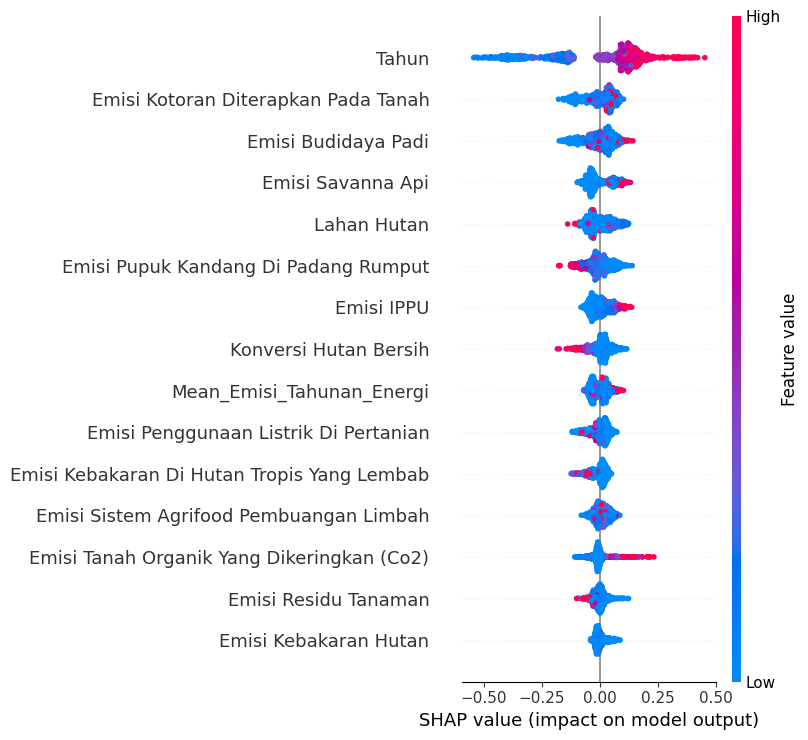

['Tahun', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi Budidaya Padi', 'Emisi Savanna Api', 'Lahan Hutan', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi IPPU', 'Konversi Hutan Bersih', 'Mean_Emisi_Tahunan_Energi', 'Emisi Penggunaan Listrik Di Pertanian', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi Sistem Agrifood Pembuangan Limbah', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Emisi Residu Tanaman', 'Emisi Kebakaran Hutan']


In [125]:
plot_shap(best_model_xgb)

## LGB Optuna

In [126]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "random_state": seed
    }

    model = LGBMRegressor(**params, verbose=-1)
    model.fit(x_train, y_train)

    preds = model.predict(x_test)
    
    mape = mean_absolute_percentage_error(y_test, preds)

    return mape

In [127]:
study_lgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study_lgb.optimize(objective_lgb, n_trials=100, show_progress_bar=True)

print(f'Best MAPE: {study_lgb.best_value}')
print(f'Best Params: {study_lgb.best_params}')

  0%|          | 0/100 [00:00<?, ?it/s]

Best MAPE: 1.1947515680068879
Best Params: {'n_estimators': 752, 'learning_rate': 0.18917685826914268, 'max_depth': 6, 'num_leaves': 8, 'subsample': 0.9877733562971425, 'colsample_bytree': 0.9804519653232987, 'min_child_samples': 36, 'min_split_gain': 0.07362962592792552, 'reg_alpha': 0.9169844308607613, 'reg_lambda': 7.417216471738049}


In [128]:
best_model_lgb = LGBMRegressor(**study_lgb.best_params, random_state=seed, verbose=-1)

best_model_lgb.fit(x_train, y_train)

train(best_model_lgb)

y_pred = best_model_lgb.predict(x_test)

mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_score:.4f}")

CV MAPE Scores: [1.48500385 0.98771827 1.62663642 0.79254064 0.80025574 0.71968166
 1.13412976 1.01176189 1.24605272 1.43037705]
Mean CV MAPE: 1.1234
Std Deviation: 0.3002
MAPE: 1.1948


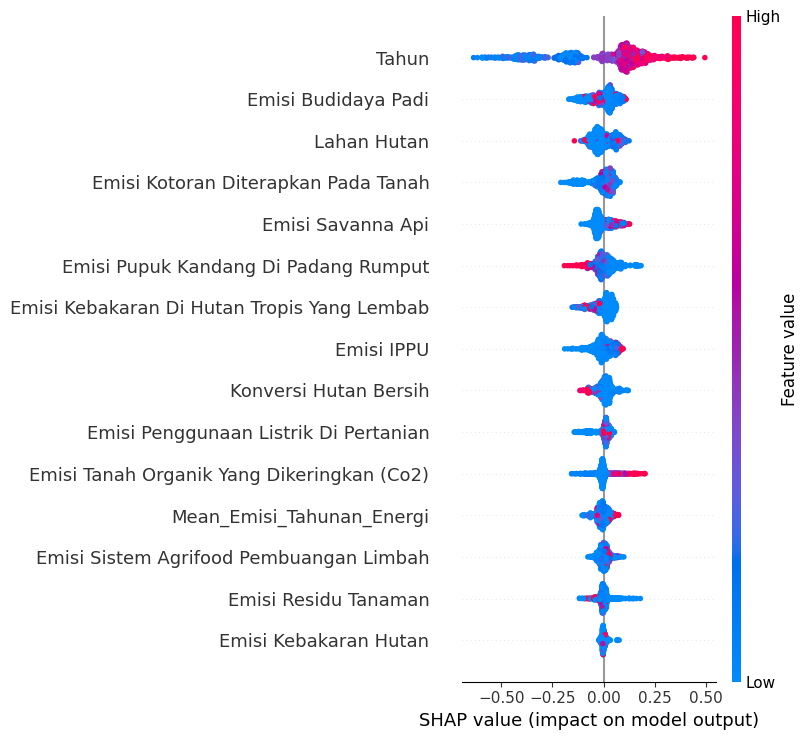

['Tahun', 'Emisi Budidaya Padi', 'Lahan Hutan', 'Emisi Kotoran Diterapkan Pada Tanah', 'Emisi Savanna Api', 'Emisi Pupuk Kandang Di Padang Rumput', 'Emisi Kebakaran Di Hutan Tropis Yang Lembab', 'Emisi IPPU', 'Konversi Hutan Bersih', 'Emisi Penggunaan Listrik Di Pertanian', 'Emisi Tanah Organik Yang Dikeringkan (Co2)', 'Mean_Emisi_Tahunan_Energi', 'Emisi Sistem Agrifood Pembuangan Limbah', 'Emisi Residu Tanaman', 'Emisi Kebakaran Hutan']


In [129]:
plot_shap(best_model_lgb)

# Main Inference

In [130]:
# model = xgb
# model = lgb
# model = best_model_xgb
model = best_model_lgb

model.fit(x, y)

test_pred = model.predict(test)

# Submission

In [131]:
submission = pd.DataFrame({'id': test.index, 'Peningkatan Suhu Rata - Rata ° C': test_pred})
submission.to_csv('submission/SUBMISSION.csv', index=False)

# Import Model

In [133]:
with open('xgb.pkl','wb') as f:
    pickle.dump(model,f)

with open('lgb.pkl','wb') as f:
    pickle.dump(model,f)

with open('optuna_xgb.pkl','wb') as f:
    pickle.dump(model,f)

with open('optuna_lgb.pkl','wb') as f:
    pickle.dump(model,f)